<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/advanced_spatial_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# üöÄ Mejoras Propuestas para Modelos Espaciales de Precipitaci√≥n

### 1. Optimizaci√≥n de Hiperpar√°metros

| Par√°metro | Valor Original | Valor Mejorado | Justificaci√≥n |
|-----------|----------------|----------------|---------------|
| Batch Size | 4 | **16** | Mayor estabilidad en gradientes |
| Learning Rate | 1e-3 | **5e-4** | Convergencia m√°s suave |
| Epochs | 50 | **100** | M√°s tiempo con early stopping |
| Patience | 6 | **10** | Evitar detenci√≥n prematura |
| Dropout | 0 | **0.2** | Regularizaci√≥n |
| L2 Reg | 0 | **1e-5** | Prevenir overfitting |

### 2. Arquitecturas Mejoradas

#### ConvLSTM con Atenci√≥n (ConvLSTM_Att)
```python
- 3 capas ConvLSTM (64‚Üí32‚Üí16 filtros)
- CBAM (Channel + Spatial Attention)
- BatchNorm + Dropout en cada capa
- Cabeza multi-escala (1√ó1, 3√ó3, 5√ó5)
```

#### ConvGRU Residual (ConvGRU_Res)
```python
- Skip connections desde input
- BatchNorm mejorado
- 2 bloques ConvGRU (64‚Üí32 filtros)
- Conexi√≥n residual final
```

#### Transformer H√≠brido (Hybrid_Trans)
```python
- Encoder CNN temporal
- Multi-head attention (4 heads)
- LSTM para agregaci√≥n temporal
- Decoder espacial
```

### 3. T√©cnicas Avanzadas

#### Learning Rate Scheduling
- **Warmup**: 5 √©pocas iniciales
- **Cosine Decay**: Reducci√≥n suave despu√©s del warmup
- **ReduceLROnPlateau**: Reducci√≥n adicional si se estanca

#### Data Augmentation
- Ruido gaussiano (œÉ=0.005)
- Preserva coherencia espacial y temporal

#### Regularizaci√≥n
- Dropout espacial (0.2)
- L2 en todos los pesos
- Batch Normalization

## üìà Mejoras Esperadas

### Por Horizonte:
- **H=1**: RMSE < 40 (mejora ~8%)
- **H=2**: RMSE < 30, R¬≤ > 0.5 (mejora significativa)
- **H=3**: RMSE < 65, R¬≤ > 0.65 (mejora ~10%)

### Por Modelo:
1. **ConvLSTM_Att**: Mejor captura de patrones espaciales relevantes
2. **ConvGRU_Res**: Mayor estabilidad y menos degradaci√≥n temporal
3. **Hybrid_Trans**: Mejor modelado de dependencias largas

## üöÄ Pr√≥ximos Pasos

### Corto Plazo:
1. Entrenar modelos con configuraci√≥n mejorada
2. Validar mejoras en m√©tricas
3. An√°lisis de errores por regi√≥n

### Medio Plazo:
1. **Ensemble Methods**: Combinar mejores modelos
2. **Multi-Task Learning**: Predecir m√∫ltiples variables
3. **Physics-Informed Loss**: Incorporar restricciones f√≠sicas

### Largo Plazo:
1. **Modelos 3D**: ConvLSTM3D para capturar altura
2. **Graph Neural Networks**: Para relaciones espaciales irregulares
3. **Uncertainty Quantification**: Intervalos de confianza

## üîç Comparaci√≥n con Baseline

El script genera autom√°ticamente comparaciones con los modelos originales, mostrando:
- % de mejora en RMSE
- Evoluci√≥n de R¬≤ por horizonte
- Tabla resumen de mejores modelos

In [1]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ IMPORTS Y CONFIGURACI√ìN ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
from __future__ import annotations
from pathlib import Path
import sys, os, gc, warnings
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, ConvLSTM2D, LSTM,SimpleRNN, LSTM, GRU, Flatten, Dense, Reshape, RepeatVector,
    Lambda, Permute, Layer, TimeDistributed, BatchNormalization, Dropout, Add,
    Add, Multiply, Concatenate, GlobalAveragePooling2D, Activation,
    LayerNormalization, MultiHeadAttention, MaxPooling2D, Embedding, Conv3D
)
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,
    CSVLogger, Callback, LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import imageio.v2 as imageio
from IPython.display import clear_output, display, Image
import json
from datetime import datetime
from typing import List, Dict, Any, Tuple, Optional



## ‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ¬†Rutas¬†‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
# ‚ñ∂Ô∏è Path configuration
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn ace_tools_open cartopy geopandas
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p / '.git').exists():
            BASE_PATH = p; break

print('BASE_PATH =', BASE_PATH)

import cartopy.crs as ccrs

# Paths
DATA_DIR = BASE_PATH / 'data' / 'output'
MODEL_OUTPUT_DIR = BASE_PATH/'models'/'output'
OUT_ROOT = BASE_PATH / 'models' / 'output' / 'advanced_spatial'
OUT_ROOT.mkdir(exist_ok=True)
BASE_MODEL_DIR = BASE_PATH / 'models' / 'output' / 'advanced_spatial' / 'base_models'
BASE_MODEL_DIR.mkdir(exist_ok=True)
MODEL_DIR = OUT_ROOT
SHAPE_DIR = BASE_PATH / 'data' / 'input' / 'shapes'
MODEL_INPUT_DIR = BASE_PATH/'data'/'input'/'shapes'
MODEL_INPUT_DIR.mkdir(parents=True, exist_ok=True)
IMAGE_DIR = MODEL_DIR/'images'
IMAGE_DIR.mkdir(exist_ok=True)
GIF_DIR = MODEL_DIR / "gifs"
GIF_DIR.mkdir(exist_ok=True)
# Dataset paths
FULL_NC = DATA_DIR / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation.nc'
FULL_NC_CLEAN = DATA_DIR / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
DEPT_GDF = gpd.read_file(SHAPE_DIR/'MGN_Departamento.shp')

print(f"üìÅ BASE_PATH: {BASE_PATH}")
print(f"üìä Dataset: {FULL_NC_CLEAN.name if FULL_NC_CLEAN.exists() else FULL_NC.name}")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ CONFIGURACI√ìN MEJORADA ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p / '.git').exists():
            BASE_PATH = p; break


warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

# GPU config
for g in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(g, True)

print("‚úÖ Imports completados")

# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ

Mounted at /content/drive
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9.3/9.3 MB 88.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 386.6/386.6 kB 34.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11.7/11.7 MB 111.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 242.5/242.5 kB 24.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.4/1.4 MB 81.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

In [2]:
# ‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Datasets ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
LAG_VARS = ['total_precipitation_lag1',
            'total_precipitation_lag2',
            'total_precipitation_lag12']

if FULL_NC_CLEAN.exists():
    print(f"üü¢ Dataset limpio localizado ‚Üí {FULL_NC_CLEAN.name}")
    ds = xr.open_dataset(FULL_NC_CLEAN)

else:
    # ============================================================
    print(f"üü† Aviso: no se encontr√≥ el dataset limpio.\n")
    ds = xr.open_dataset(FULL_NC)
    print("\nüìä  Resumen global de NaNs")
    print("‚îÄ"*55)
    for var in LAG_VARS:
        arr    = ds[var].values
        total  = arr.size
        n_nans = int(np.isnan(arr).sum())
        print(f"{var:<28}: {n_nans:>8,} / {total:,}  ({n_nans/total:6.2%})")

    # ============================================================
    print("\nüïí  Fechas con NaNs por variable")
    print("‚îÄ"*55)
    for var in LAG_VARS:
        arr         = ds[var].values
        nan_per_ts  = np.isnan(arr).reshape(len(ds.time), -1).sum(axis=1)
        if nan_per_ts.sum() == 0:
            print(f"{var}: sin NaNs ‚úîÔ∏è")
            continue

        df_nan = (pd
                  .DataFrame({"time": pd.to_datetime(ds.time.values),
                              "na_cells": nan_per_ts})
                  .query("na_cells > 0"))

        # primeras 3 y √∫ltimas 3 fechas con NaNs
        head = df_nan.head(3).to_string(index=False)
        tail = df_nan.tail(3).to_string(index=False)
        last = df_nan["time"].iloc[-1].strftime("%Y-%m")

        print(f"\n{var}")
        print(head)
        if len(df_nan) > 6:
            print("   ‚Ä¶")
        print(tail)
        print(f"   ‚á¢  √∫ltima fecha con NaNs: {last}")

    # ============================================================
    # Primera fecha en la que las TRES variables est√°n 100 % limpias
    # ------------------------------------------------------------
    def last_nan_index(var: str) -> int:
        """√çndice del √∫ltimo timestamp que contiene al menos un NaN en `var`."""
        nan_per_ts = np.isnan(ds[var].values).reshape(len(ds.time), -1).sum(axis=1)
        idxs       = np.where(nan_per_ts > 0)[0]
        return idxs[-1] if len(idxs) else -1

    last_nan_any = max(last_nan_index(v) for v in LAG_VARS)
    first_clean  = pd.to_datetime(ds.time.values[last_nan_any + 1])

    print("\nPrimera fecha 100 % libre de NaNs en TODOS los lags:",
          first_clean.strftime("%Y-%m"))

    ds_clean = ds.sel(time=~(ds['time.year'] == 1981))   # descarta TODO 1981

    print("üîé  Timestamps antes :", len(ds.time))
    print("üîé  Timestamps despu√©s:", len(ds_clean.time))

    # 3) Guarda nuevo archivo NetCDF
    ds_clean.to_netcdf(FULL_NC_CLEAN, mode='w')
    print(f"üíæ  Dataset sin 1981 guardado en {FULL_NC_CLEAN}")

    # 4) (-- opcional --)  verifica que ya no queden NaNs en los lags
    LAG_VARS = ['total_precipitation_lag1',
                'total_precipitation_lag2',
                'total_precipitation_lag12']

    print("\nüìä  NaNs restantes tras quitar 1981")
    print("‚îÄ"*50)
    for var in LAG_VARS:
        n_nan = int(np.isnan(ds_clean[var].values).sum())
        print(f"{var:<28}: {n_nan:,} NaNs")

    ds = ds_clean
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ

üü¢ Dataset limpio localizado ‚Üí complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc


In [3]:
# ‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Shapes ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
lat, lon    = len(ds.latitude), len(ds.longitude)
cells       = lat * lon
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ

# ‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Hyper‚Äëpar√°metros globales ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
INPUT_WINDOW   = 60
HORIZON        = 3
TARGET_VAR     = 'total_precipitation'
EPOCHS         = 120
BATCH_SIZE     = 8           # tama√±o peque√±o¬†‚Üí¬†menor RAM¬†GPU
PATIENCE       = 100
LR             = 1e-3
L2_REG         = 1e-5 # Regularizaci√≥n L2
DROPOUT        = 0.2 # Regularizaci√≥n
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ

# ‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ¬†M√©tricas¬†‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ

def evaluate(y_true: np.ndarray, y_pred: np.ndarray):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5))) * 100
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ

# ‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ¬†Modelo base ConvLSTM¬†‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ

@tf.keras.utils.register_keras_serializable()
def tile_step_emb(batch_ref, step_emb_tab):
    # Forma est√°tica (TensorShape / TensorSpec)
    if isinstance(batch_ref, (tf.TensorShape, tf.TensorSpec)):
        return tf.TensorShape([batch_ref[0],
                               step_emb_tab.shape[0],
                               step_emb_tab.shape[1]])
    # Ejecuci√≥n
    b   = tf.shape(batch_ref)[0]
    emb = tf.expand_dims(step_emb_tab, 0)
    return tf.tile(emb, [b, 1, 1])
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ
custom = {'tile_step_emb': tile_step_emb}

def _build_convlstm_ed(
        *,
        input_window: int,
        output_horizon: int,
        spatial_height: int,
        spatial_width: int,
        n_features: int,
        n_filters: int = 64,
        n_heads: int = 4,
        use_attention: bool = True,
        use_positional_emb: bool = True,
        lr: float = 1e-3
    ) -> Model:
    """
    Encoder-Decoder ConvLSTM + GRU.
    Si `use_positional_emb` = True a√±ade un embedding del paso de salida
    que evita que el modelo genere la misma predicci√≥n en todos los horizontes.
    """

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Encoder ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    enc_inputs = Input(
        shape=(input_window, spatial_height, spatial_width, n_features),
        name="enc_input"
    )

    x = ConvLSTM2D(n_filters, (3, 3), padding='same',
                   return_sequences=True,  name="enc_lstm_1")(enc_inputs)
    x = ConvLSTM2D(n_filters // 2, (3, 3), padding='same',
                   return_sequences=False, name="enc_lstm_2")(x)

    # ‚îÄ‚îÄ Aplana grilla y repite contexto T_out veces ‚îÄ‚îÄ
    flat = Flatten(name="flatten_spatial")(x)                 # (B, H¬∑W¬∑C)
    ctx  = RepeatVector(output_horizon, name="context")(flat) # (B, T_out, H¬∑W¬∑C)

    # ‚îÄ‚îÄ Positional embedding CORREGIDO ‚îÄ‚îÄ
    if use_positional_emb:
        # Crear IDs de pasos como input constante
        step_ids_input = Input(shape=(output_horizon,), dtype=tf.int32, name="step_ids")

        # Embedding layer
        step_emb_layer = Embedding(output_horizon, n_filters, name="step_embedding")
        step_emb = step_emb_layer(step_ids_input)  # (B, T_out, D)

        # Concatenar con contexto
        dec_in = Concatenate(name="dec_concat")([ctx, step_emb])

        # Actualizar inputs del modelo
        model_inputs = [enc_inputs, step_ids_input]
    else:
        dec_in = ctx
        model_inputs = enc_inputs

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Decoder temporal ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    dec = GRU(2 * n_filters, return_sequences=True, name="dec_gru")(dec_in) # (B, T_out, 2¬∑F)

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Attention (opcional) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    if use_attention:
        attn = MultiHeadAttention(num_heads=n_heads,
                                  key_dim=n_filters,
                                  dropout=0.1,
                                  name="mha")(dec, dec)
        dec  = Add(name="mha_residual")([dec, attn])
        dec  = LayerNormalization(name="mha_norm")(dec)

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Proyecci√≥n a grilla ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    proj = TimeDistributed(
        Dense(spatial_height * spatial_width, activation='linear'),
        name="dense_proj"
    )(dec)                                                    # (B, T_out, H¬∑W)

    out = Reshape(
        (output_horizon, spatial_height, spatial_width, 1),
        name="reshape_out"
    )(proj)

    name = ("ConvLSTM_ED_Attn_PE" if use_attention else "ConvLSTM_ED_PE") \
           if use_positional_emb else \
           ("ConvLSTM_ED_Attn"     if use_attention else "ConvLSTM_ED")

    model = Model(model_inputs, out, name=name)
    model.compile(optimizer=Adam(lr), loss='mse')
    return model

# Factories ---------------------------------------------------

def factory_no_attn(**kw):
    return _build_convlstm_ed(use_attention=False, **kw)

def factory_attn(**kw):
    return _build_convlstm_ed(use_attention=True, **kw)
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ

# ‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Experiments &¬†Folds ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
# ‚ñ∏ Solo mostramos los tres primeros niveles; a√±ade los dem√°s igual
BASE_FEATURES = [
    'year','month','month_sin','month_cos','doy_sin','doy_cos',
    'max_daily_precipitation','min_daily_precipitation','daily_precipitation_std',
    'elevation','slope','aspect'
]
ELEV_CLUSTER = ['elev_high','elev_med','elev_low']
KCE_FEATURES = BASE_FEATURES + ELEV_CLUSTER
PAFC_FEATURES= KCE_FEATURES + ['total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag12']

FOLDS = {'F1': {'year': 2018,'active': True}}

EXPERIMENTS: Dict[str, Dict[str, Any]] = {
    'ConvLSTM-ED': {
        'active': True,
        'feature_list': BASE_FEATURES,
        'builder': factory_attn, #factory_no_attn,
        'n_filters': 64,
        'n_heads'  : 4
    },
    'ConvLSTM-ED-KCE': {
        'active': True,
        'feature_list': KCE_FEATURES,
        'builder': factory_attn,
        'n_filters': 64,
        'n_heads'  : 4,
    },
    'ConvLSTM-ED-KCE-PAFC': {
        'active': True,
        'feature_list': PAFC_FEATURES,
        'builder': factory_attn,
        'n_filters': 96,
        'n_heads'  : 6,
    },
}
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ

# ‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Ventanas deslizadas ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ

def make_windows(mask:np.ndarray, allow_past_context:bool)->tuple[np.ndarray,np.ndarray]:
    """Genera ventanas **descartando** las que contienen NaNs.  # üî∏ NEW"""
    seq_X, seq_y = [], []
    lim = len(mask) - INPUT_WINDOW - HORIZON + 1
    for start in range(lim):
        end_w = start + INPUT_WINDOW; end_y = end_w + HORIZON
        if allow_past_context:
            if not mask[end_w:end_y].all():
                continue
        else:
            if not mask[start:end_y].all():
                continue
        Xw = Xarr[start:end_w]; yw = yarr[end_w:end_y]
        if np.isnan(Xw).any() or np.isnan(yw).any():
            continue  # üî∏ NEW¬†‚Äî descarta ventana con NaNs
        seq_X.append(Xw); seq_y.append(yw)
    return np.array(seq_X), np.array(seq_y)


# ‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Bucle principal de entrenamiento ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
RESULTS: List[Dict[str, Any]] = []

# üî∏ NEW helper ------------------------------------------------

def _impute_nans(a:np.ndarray, per_feature_mean:np.ndarray|None=None, is_target:bool=False)->np.ndarray:
    """Imputa NaNs restantes (seguridad extra)."""
    if not np.isnan(a).any():
        return a
    if is_target:
        a[np.isnan(a)] = 0.0  # üî∏ NEW ‚Äì¬†0 para y
        return a
    if per_feature_mean is None:
        raise ValueError('per_feature_mean required for imputing X')
    flat = a.reshape(-1, a.shape[-1])
    nan_idx = np.isnan(flat)
    for f in range(a.shape[-1]):
        flat[nan_idx[:,f], f] = per_feature_mean[f]  # üî∏ NEW
    return flat.reshape(a.shape)
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ

def run_all_experiments():
    times = pd.to_datetime(ds.time.values)
    total = sum(e['active'] for e in EXPERIMENTS.values()) * sum(f['active'] for f in FOLDS.values())
    cnt   = 0

    for exp_name, exp_cfg in EXPERIMENTS.items():
        if not exp_cfg['active']:
            continue
        vars_     = exp_cfg['feature_list']
        builder   = exp_cfg['builder']      # f√°brica espec√≠fica
        n_filters = exp_cfg.get('n_filters',64)
        n_heads   = exp_cfg.get('n_heads',4)

        # ‚îÄ Pre‚Äëload features por experimento ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
        global Xarr, yarr
        Xarr = ds[vars_].to_array().transpose('time','latitude','longitude','variable').values.astype(np.float32)
        yarr = ds[TARGET_VAR].values.astype(np.float32)
        feats = Xarr.shape[-1]

        for fold_name, fold_cfg in FOLDS.items():
            if not fold_cfg['active']:
                continue
            cnt += 1
            year_val = fold_cfg['year']
            print(f"\n‚ñ∂Ô∏è  [{cnt}/{total}] {exp_name} ‚Äì {fold_name} (val={year_val})")

            mask_val = times.year == year_val
            mask_tr  = ~mask_val
            if mask_val.sum() < HORIZON:
                print("‚ö†Ô∏è¬†A√±o sin pasos suficientes ‚Üí¬†skip"); continue

            X_tr, y_tr = make_windows(mask_tr,  allow_past_context=False)
            X_va, y_va = make_windows(mask_val, allow_past_context=True)
            print(f"Ventanas¬†train: {len(X_tr)} ¬∑ val: {len(X_va)}")
            if len(X_tr)==0 or len(X_va)==0:
                print("‚ö†Ô∏è¬†Sin ventanas v√°lidas ‚Üí¬†skip"); continue

            # üî∏ NEW¬†‚Äî Imputaci√≥n de seguridad
            feat_mean = np.nanmean(X_tr.reshape(-1,feats),axis=0)
            X_tr = _impute_nans(X_tr,feat_mean); X_va=_impute_nans(X_va,feat_mean)
            y_tr = _impute_nans(y_tr,is_target=True); y_va=_impute_nans(y_va,is_target=True)

            # ‚îÄ Scaling (fit solo en train) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
            sx = StandardScaler().fit(X_tr.reshape(-1, feats))
            sy = StandardScaler().fit(y_tr.reshape(-1, 1))
            X_tr_sc = sx.transform(X_tr.reshape(-1, feats)).reshape(X_tr.shape)
            X_va_sc = sx.transform(X_va.reshape(-1, feats)).reshape(X_va.shape)
            y_tr_sc = sy.transform(y_tr.reshape(-1, 1)).reshape(y_tr.shape)[..., None]
            y_va_sc = sy.transform(y_va.reshape(-1, 1)).reshape(y_va.shape)[..., None]

            # ‚îÄ Build & train model (factory) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
            tag        = f"{exp_name.replace('+','_')}_{fold_name}"
            model_path = BASE_MODEL_DIR / f"{tag}.keras"
            if model_path.exists():
                print(f"‚è©¬†{tag} ya existe ‚Üí¬†skip"); continue

            model = builder(
                input_window=INPUT_WINDOW,
                output_horizon=HORIZON,
                spatial_height=lat,
                spatial_width=lon,
                n_features=feats,
                n_filters=n_filters,
                n_heads=n_heads,
                lr=LR
            )

            # Preparar step_ids para entrenamiento
            step_ids_train = np.tile(np.arange(HORIZON), (len(X_tr_sc), 1))
            step_ids_val = np.tile(np.arange(HORIZON), (len(X_va_sc), 1))

            # Verificar si el modelo usa positional embedding
            uses_pe = len(model.inputs) > 1

            if uses_pe:
                X_train_input = [X_tr_sc, step_ids_train]
                X_val_input = [X_va_sc, step_ids_val]
            else:
                X_train_input = X_tr_sc
                X_val_input = X_va_sc

            es   = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
            hist = model.fit(X_train_input, y_tr_sc, validation_data=(X_val_input, y_va_sc), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

            # ‚îÄ Evaluaci√≥n ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
            if uses_pe:
                y_hat_sc = model.predict([X_va_sc, step_ids_val], verbose=0)
            else:
                y_hat_sc = model.predict(X_va_sc, verbose=0)
            y_hat    = sy.inverse_transform(y_hat_sc.reshape(-1,1)).reshape(y_hat_sc.shape)
            y_true   = sy.inverse_transform(y_va_sc.reshape(-1,1)).reshape(y_va_sc.shape)

            rmse, mae, mape, r2 = evaluate(y_true.ravel(), y_hat.ravel())
            RESULTS.append(dict(experiment=exp_name, fold=fold_name, RMSE=rmse, MAE=mae, MAPE=mape, R2=r2, epochs=len(hist.history['loss'])))

            # ‚îÄ Guardado artefactos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
            model.save(model_path)
            plt.figure(); plt.plot(hist.history['loss'], label='train'); plt.plot(hist.history['val_loss'], label='val'); plt.legend(); plt.title(tag); plt.savefig(IMAGE_DIR/f"{tag}.png"); plt.close()

            # Verificar que las predicciones var√≠an entre horizontes
            print(f"Verificaci√≥n de predicciones para {tag}:")
            for h in range(HORIZON):
                pred_h = y_hat[0, h, ..., 0]  # Primera muestra, horizonte h
                print(f"  H{h+1}: min={pred_h.min():.3f}, max={pred_h.max():.3f}, mean={pred_h.mean():.3f}, std={pred_h.std():.3f}")

            # Usar la √∫ltima ventana de validaci√≥n para mejor visualizaci√≥n
            last_idx = min(len(y_hat)-1, 10)  # Usar una de las √∫ltimas ventanas
            _generate_gif(y_true[last_idx], y_hat[last_idx], tag)
            print(f"‚úÖ¬†Guardado {model_path.name}")

    # ‚îÄ M√©tricas globales ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    df = pd.DataFrame(RESULTS)
    out_csv = BASE_MODEL_DIR / "metrics_experiments_folds.csv"
    df.to_csv(out_csv, index=False)
    print(f"\nüìë¬†Tabla de m√©tricas en {out_csv}")
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ

# ‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Generador de GIF ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ

def _generate_gif(y_true_sample, y_pred_sample, tag):
    pcm_min, pcm_max = 0, np.max(y_pred_sample)
    frames = []
    for h in range(HORIZON):
        pmap = y_pred_sample[h, ..., 0]
        fig, ax = plt.subplots(1,1, figsize=(6,5), subplot_kw={'projection':ccrs.PlateCarree()})
        mesh = ax.pcolormesh(ds.longitude, ds.latitude, pmap, cmap='Blues', shading='nearest', vmin=pcm_min, vmax=pcm_max, transform=ccrs.PlateCarree())
        ax.coastlines(); ax.gridlines(draw_labels=True)
        ax.set_title(f"{tag} ‚Äì H{h+1}")
        fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04)
        tmp = GIF_DIR/f"tmp_{tag}_h{h}.png"
        fig.savefig(tmp, bbox_inches='tight'); plt.close(fig)
        frames.append(imageio.imread(tmp)); tmp.unlink(missing_ok=True)
    gif_path = GIF_DIR/f"{tag}.gif"
    imageio.mimsave(gif_path, frames, fps=0.5)
    print(f"üíæ¬†GIF {gif_path.name} listo")
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ

# ‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ¬†Bucle principal ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
run_all_experiments()
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ


# üìà **Evaluador para salidas espaciales ConvLSTM**

#‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Experiments &¬†Folds ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
@tf.keras.utils.register_keras_serializable()
def tile_step_emb(batch_ref, step_emb_tab):
    """
    Replica la tabla de embedding (T_out, D) ‚Üí (B, T_out, D).

    ¬∑ Durante la inferencia de forma, `batch_ref` es TensorShape
      ‚Üí devolvemos TensorShape (None, T_out, D).
    ¬∑ En ejecuci√≥n, `batch_ref` es tensor
      ‚Üí devolvemos tensor (B, T_out, D).

    ‚ñ∏ `step_emb_tab` SIEMPRE llega desde el cierre de la Lambda original,
      as√≠ que NO lo pongas opcional.
    """
    # ‚Äî‚Äî‚Äî 1) Forma est√°tica ‚Äî‚Äî‚Äî
    if isinstance(batch_ref, (tf.TensorShape, tf.TensorSpec)):
        return tf.TensorShape([batch_ref[0],
                               step_emb_tab.shape[0],
                               step_emb_tab.shape[1]])

    # ‚Äî‚Äî‚Äî 2) Ejecuci√≥n ‚Äî‚Äî‚Äî
    b   = tf.shape(batch_ref)[0]
    emb = tf.expand_dims(step_emb_tab, 0)    # (1, T_out, D)
    return tf.tile(emb, [b, 1, 1])           # (B, T_out, D)
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ
custom = {'tile_step_emb': tile_step_emb}
# ‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ


def quick_plot(ax,data,cmap,title,date_label,vmin=None,vmax=None):
    mesh=ax.pcolormesh(ds.longitude,ds.latitude,data,cmap=cmap,shading='nearest',vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
    ax.coastlines(); ax.add_geometries(DEPT_GDF.geometry,ccrs.PlateCarree(),edgecolor='black',facecolor='none',linewidth=1)
    gl=ax.gridlines(draw_labels=True); gl.top_labels=False; gl.right_labels=False
    ax.set_title(f"{title}\n{date_label}",pad=10); return mesh

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Recuperamos diccionario EXPERIMENTS (del bloque de entrenamiento) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
from typing import Dict
EXPERIMENTS:Dict[str,Dict[str,Any]] = {
    'ConvLSTM-ED':              {'feature_list': "+".join(BASE_FEATURES).split("+")},
    'ConvLSTM-ED-KCE':          {'feature_list': "+".join(KCE_FEATURES).split("+")},
    'ConvLSTM-ED-KCE-PAFC':     {'feature_list': "+".join(PAFC_FEATURES).split("+")},
    #¬†otros experimentos
}

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî Evaluaci√≥n ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
all_metrics=[]; times=pd.to_datetime(ds.time.values)
for mpath in sorted(BASE_MODEL_DIR.glob("*.keras")):
    tag   = mpath.stem                        # p.ej. ConvLSTM-ED_F1
    parts = tag.split("_")
    fold  = parts[-1]                         # F1
    exp_token = "_".join(parts[:-1])
    exp_name  = exp_token.replace("_","+")  # vuelve al nombre original con +
    if exp_name not in EXPERIMENTS:
        print("‚ö†Ô∏è¬†Exp no encontrado para",tag); continue
    feats = EXPERIMENTS[exp_name]['feature_list']
    print(f"\nüîç Evaluando {tag} ‚Ä¶")

    # ‚Äî Extracci√≥n de arrays ‚Äî
    Xarr = ds[feats].to_array().transpose('time','latitude','longitude','variable').values.astype(np.float32)
    yarr = ds[TARGET_VAR].values.astype(np.float32)
    T,_,_,F = Xarr.shape
    Xfull = Xarr; yfull=yarr  # mantenemos (T,H,W,F)

    # ventana final (id√©ntica l√≥gica del cuaderno original)
    start=T-INPUT_WINDOW-HORIZON; end_w=start+INPUT_WINDOW; end_y=end_w+HORIZON
    X_eval = Xfull[start:end_w]                 # (60,H,W,F)
    y_eval = yfull[end_w:end_y]                 # (3,H,W)

    # ‚Äî Scalers (fit vectorizado) ‚Äî
    flat_X = Xfull.reshape(-1, F)      # (T¬∑H¬∑W, F)
    flat_y = yfull.reshape(-1, 1)      # (T¬∑H¬∑W, 1)

    sx = StandardScaler().fit(flat_X)
    sy = StandardScaler().fit(flat_y)

    Xe_sc = sx.transform(X_eval.reshape(-1, F)).reshape(1, INPUT_WINDOW, lat, lon, F)
    ye_sc = sy.transform(y_eval.reshape(-1, 1)).reshape(1, HORIZON, lat, lon, 1)


    model = tf.keras.models.load_model(
    mpath,
    compile=False,
    custom_objects={'tile_step_emb': tile_step_emb}
    )

    # Verificar si el modelo usa positional embedding
    uses_pe = len(model.inputs) > 1

    if uses_pe:
        step_ids_eval = np.tile(np.arange(HORIZON), (1, 1))
        yhat_sc = model.predict([Xe_sc, step_ids_eval], verbose=0)  # (1,3,H,W,1)
    else:
        yhat_sc = model.predict(Xe_sc, verbose=0)  # (1,3,H,W,1)
    print(f"Verificaci√≥n de predicciones para {tag}:")
    for h in range(HORIZON):
        pred_h = yhat_sc[0, h, ..., 0]  # Primera muestra, horizonte h
        print(f"  H{h+1}: min={pred_h.min():.3f}, max={pred_h.max():.3f}, mean={pred_h.mean():.3f}, std={pred_h.std():.3f}")
    # Verificar si las predicciones son id√©nticas
    if HORIZON > 1:
        diff_h1_h2 = np.abs(yhat_sc[0, 0] - yhat_sc[0, 1]).mean()
        print(f"  Diferencia promedio H1 vs H2: {diff_h1_h2:.6f}")
    yhat   = sy.inverse_transform(yhat_sc.reshape(-1,1)).reshape(HORIZON,lat,lon)
    ytrue  = y_eval

    # ‚Äî M√©tricas por horizonte ‚Äî
    for h in range(HORIZON):
        yt = ytrue[h].ravel()
        yp = yhat[h].ravel()

        # ---------- filtro NaN / ¬±‚àû ----------
        mask = np.isfinite(yt) & np.isfinite(yp)
        if mask.sum() == 0:          # ventana vac√≠a ‚Üí se ignora
            print(f"   ¬∑ h={h+1}: todos los valores son NaN/Inf ‚Üí skip")
            continue
        yt, yp = yt[mask], yp[mask]
        # -------------------------------------

        rmse = np.sqrt(mean_squared_error(yt, yp))
        mae  = mean_absolute_error(yt, yp)
        mape = np.mean(np.abs((yt - yp) / (yt + 1e-5))) * 100
        r2   = r2_score(yt, yp)

        all_metrics.append(dict(
            model      = tag,
            experiment = exp_name,
            fold       = fold,
            horizon    = h + 1,
            RMSE       = rmse,
            MAE        = mae,
            MAPE       = mape,
            R2         = r2
        ))

    # ‚Äî Figura Real vs¬†Pred vs¬†MAPE ‚Äî
    fig,axes=plt.subplots(HORIZON,3,figsize=(14,4*HORIZON),subplot_kw={'projection':ccrs.PlateCarree()})
    dates=pd.date_range(times[end_w],periods=HORIZON,freq='MS')
    vmin=0; vmax=max(yhat.max(),ytrue.max())
    for h in range(HORIZON):
        quick_plot(axes[h,0],ytrue[h],'Blues',f"Real h={h+1}",dates[h].strftime('%Y-%m'),vmin,vmax)
        quick_plot(axes[h,1],yhat [h],'Blues',f"Pred h={h+1}",dates[h].strftime('%Y-%m'),vmin,vmax)
        err=np.clip(np.abs((ytrue[h]-yhat[h])/(ytrue[h]+1e-5))*100,0,100)
        quick_plot(axes[h,2],err,'Reds',f"MAPE% h={h+1}",dates[h].strftime('%Y-%m'),0,100)
    fig.suptitle(f"{tag}  ‚Äî¬†Eval final ventana",fontsize=16); fig.tight_layout();
    fig.savefig(BASE_MODEL_DIR/f"fig_{tag}.png"); plt.close(fig)

    # ‚Äî GIF ‚Äî
    frames=[]; pcm_min,pcm_max=0,yhat.max()
    for h in range(HORIZON):
        figg,ax=plt.subplots(1,1,figsize=(6,5),subplot_kw={'projection':ccrs.PlateCarree()})
        m=ax.pcolormesh(ds.longitude,ds.latitude,yhat[h],cmap='Blues',shading='nearest',vmin=pcm_min,vmax=pcm_max,transform=ccrs.PlateCarree())
        ax.coastlines(); ax.set_title(f"{tag} ‚Äì H{h+1}"); figg.colorbar(m,ax=ax,fraction=0.046,pad=0.04)
        tmp=GIF_DIR/f"tmp_{tag}_{h}.png"; figg.savefig(tmp,bbox_inches='tight'); plt.close(figg)
        frames.append(imageio.imread(tmp)); tmp.unlink(missing_ok=True)
    imageio.mimsave(GIF_DIR/f"{tag}.gif",frames,fps=0.5)
    print("üíæ GIF",f"{tag}.gif","creado")

# ‚Äî‚Äî‚Äî Guardar tabla ‚Äî‚Äî‚Äî
pd.DataFrame(all_metrics).to_csv(BASE_MODEL_DIR/'metrics_eval.csv',index=False)
print("üìë¬†M√©tricas guardadas en",BASE_MODEL_DIR/'metrics_eval.csv')



‚ñ∂Ô∏è  [1/3] ConvLSTM-ED ‚Äì F1 (val=2018)
Ventanas¬†train: 382 ¬∑ val: 10
‚è©¬†ConvLSTM-ED_F1 ya existe ‚Üí¬†skip

‚ñ∂Ô∏è  [2/3] ConvLSTM-ED-KCE ‚Äì F1 (val=2018)
Ventanas¬†train: 382 ¬∑ val: 10
‚è©¬†ConvLSTM-ED-KCE_F1 ya existe ‚Üí¬†skip

‚ñ∂Ô∏è  [3/3] ConvLSTM-ED-KCE-PAFC ‚Äì F1 (val=2018)
Ventanas¬†train: 382 ¬∑ val: 10
‚è©¬†ConvLSTM-ED-KCE-PAFC_F1 ya existe ‚Üí¬†skip

üìë¬†Tabla de m√©tricas en /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/base_models/metrics_experiments_folds.csv

üîç Evaluando ConvLSTM-ED-KCE-PAFC_F1 ‚Ä¶
Verificaci√≥n de predicciones para ConvLSTM-ED-KCE-PAFC_F1:
  H1: min=-1.351, max=1.117, mean=-0.762, std=0.390
  H2: min=-1.351, max=1.117, mean=-0.762, std=0.390
  H3: min=-1.351, max=1.117, mean=-0.762, std=0.390
  Diferencia promedio H1 vs H2: 0.000000
üíæ GIF ConvLSTM-ED-KCE-PAFC_F1.gif creado

üîç Evaluando ConvLSTM-ED-KCE_F1 ‚Ä¶
Verificaci√≥n de predicciones para ConvLSTM-ED-KCE_F1:
  H1: min=-1.032, max=1.954, me

In [4]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ CAPAS DE ATENCI√ìN ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

class SpatialAttention(Layer):
    """Atenci√≥n espacial para resaltar regiones importantes"""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.conv = Conv2D(1, (7, 7), padding='same', activation='sigmoid')
        super().build(input_shape)

    def call(self, inputs):
        # Calcular estad√≠sticas del canal
        avg_pool = K.mean(inputs, axis=-1, keepdims=True)
        max_pool = K.max(inputs, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])

        # Generar mapa de atenci√≥n
        attention = self.conv(concat)

        return Multiply()([inputs, attention])

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        return config


class ChannelAttention(Layer):
    """Atenci√≥n de canal para ponderar features importantes"""

    def __init__(self, reduction_ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.fc1 = Dense(channels // self.reduction_ratio, activation='relu')
        self.fc2 = Dense(channels, activation='sigmoid')
        super().build(input_shape)

    def call(self, inputs):
        # Global pooling
        avg_pool = GlobalAveragePooling2D()(inputs)
        max_pool = K.max(inputs, axis=[1, 2])

        # Shared MLP
        avg_out = self.fc2(self.fc1(avg_pool))
        max_out = self.fc2(self.fc1(max_pool))

        # Combinar
        attention = avg_out + max_out
        attention = K.expand_dims(K.expand_dims(attention, 1), 1)

        return Multiply()([inputs, attention])

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_ratio': self.reduction_ratio
        })
        return config


class CBAM(Layer):
    """Convolutional Block Attention Module"""

    def __init__(self, reduction_ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channel_attention = ChannelAttention(self.reduction_ratio)
        self.spatial_attention = SpatialAttention()
        super().build(input_shape)

    def call(self, inputs):
        x = self.channel_attention(inputs)
        x = self.spatial_attention(x)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_ratio': self.reduction_ratio
        })
        return config

print("‚úÖ Capas de atenci√≥n implementadas")


‚úÖ Capas de atenci√≥n implementadas


In [5]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ CAPAS AVANZADAS ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

class ConvGRU2DCell(Layer):
    """Celda ConvGRU2D mejorada con BatchNorm"""

    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', use_batch_norm=True, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.recurrent_activation = tf.keras.activations.get(recurrent_activation)
        self.use_batch_norm = use_batch_norm
        self.state_size = (filters,)

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Kernels
        self.kernel = self.add_weight(
            shape=(*self.kernel_size, input_dim, self.filters * 3),
            initializer='glorot_uniform',
            regularizer=l1_l2(l1=0, l2=L2_REG),
            name='kernel'
        )

        self.recurrent_kernel = self.add_weight(
            shape=(*self.kernel_size, self.filters, self.filters * 3),
            initializer='orthogonal',
            regularizer=l1_l2(l1=0, l2=L2_REG),
            name='recurrent_kernel'
        )

        self.bias = self.add_weight(
            shape=(self.filters * 3,),
            initializer='zeros',
            name='bias'
        )

        if self.use_batch_norm:
            self.bn_x = BatchNormalization()
            self.bn_h = BatchNormalization()

        super().build(input_shape)

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]

        # Convoluciones
        x_conv = K.conv2d(inputs, self.kernel, padding=self.padding)
        h_conv = K.conv2d(h_tm1, self.recurrent_kernel, padding=self.padding)

        if self.use_batch_norm:
            x_conv = self.bn_x(x_conv, training=training)
            h_conv = self.bn_h(h_conv, training=training)

        x_z, x_r, x_h = tf.split(x_conv, 3, axis=-1)
        h_z, h_r, h_h = tf.split(h_conv, 3, axis=-1)
        b_z, b_r, b_h = tf.split(self.bias, 3)

        # Gates
        z = self.recurrent_activation(x_z + h_z + b_z)
        r = self.recurrent_activation(x_r + h_r + b_r)

        # Hidden state
        h_candidate = self.activation(x_h + r * h_h + b_h)
        h = (1 - z) * h_tm1 + z * h_candidate

        return h, [h]


class ConvGRU2D(Layer):
    """ConvGRU2D mejorado con soporte para BatchNorm y Dropout"""

    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', return_sequences=False,
                 use_batch_norm=True, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.recurrent_activation = recurrent_activation
        self.return_sequences = return_sequences
        self.use_batch_norm = use_batch_norm
        self.dropout = dropout

        self.cell = ConvGRU2DCell(
            filters, kernel_size, padding, activation,
            recurrent_activation, use_batch_norm
        )

        if dropout > 0:
            self.dropout_layer = Dropout(dropout)

    def build(self, input_shape):
        self.cell.build(input_shape[2:])
        super().build(input_shape)

    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        height = tf.shape(inputs)[2]
        width = tf.shape(inputs)[3]

        # Estado inicial
        initial_state = tf.zeros((batch_size, height, width, self.filters))

        # Procesar secuencia
        outputs = []
        state = initial_state

        for t in range(inputs.shape[1]):
            output, [state] = self.cell(inputs[:, t], [state], training=training)

            if self.dropout > 0:
                output = self.dropout_layer(output, training=training)

            outputs.append(output)

        outputs = tf.stack(outputs, axis=1)

        if self.return_sequences:
            return outputs
        else:
            return outputs[:, -1]

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'activation': self.activation,
            'recurrent_activation': self.recurrent_activation,
            'return_sequences': self.return_sequences,
            'use_batch_norm': self.use_batch_norm,
            'dropout': self.dropout
        })
        return config

print("‚úÖ Capas ConvGRU mejoradas implementadas")


‚úÖ Capas ConvGRU mejoradas implementadas


In [6]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ MODEL BUILDERS AVANZADOS ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

def _advanced_spatial_head(x, use_attention=True):
    """Cabeza de proyecci√≥n mejorada con atenci√≥n opcional"""

    if use_attention:
        x = CBAM()(x)

    # Multi-scale processing
    conv1 = Conv2D(HORIZON, (1, 1), padding='same')(x)
    conv3 = Conv2D(HORIZON, (3, 3), padding='same')(x)
    conv5 = Conv2D(HORIZON, (5, 5), padding='same')(x)

    # Combine multi-scale features
    x = Add()([conv1, conv3, conv5])
    x = BatchNormalization()(x)
    x = Activation('linear')(x)

    # Reshape to output format usando Permute y Reshape
    x = Permute((3, 1, 2))(x)  # De (batch, H, W, HORIZON) a (batch, HORIZON, H, W)
    x = Reshape((HORIZON, lat, lon, 1))(x)  # A√±adir dimensi√≥n de canal

    return x


def build_convlstm_attention(n_feats: int):
    """ConvLSTM con mecanismo de atenci√≥n"""
    inp = Input(shape=(INPUT_WINDOW, lat, lon, n_feats))

    # Primera capa con m√°s filtros
    x = ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0, l2=L2_REG))(inp)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)

    # Segunda capa con atenci√≥n
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0, l2=L2_REG))(x)
    x = BatchNormalization()(x)

    # Aplicar atenci√≥n temporal
    x = TimeDistributed(CBAM())(x)

    # Capa final
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False,
                   kernel_regularizer=l1_l2(l1=0, l2=L2_REG))(x)
    x = BatchNormalization()(x)

    out = _advanced_spatial_head(x)
    return Model(inp, out, name='ConvLSTM_Attention')


def build_convgru_residual(n_feats: int):
    """ConvGRU con skip connections"""
    inp = Input(shape=(INPUT_WINDOW, lat, lon, n_feats))

    # Encoder path
    enc1 = ConvGRU2D(64, (3, 3), return_sequences=True,
                     use_batch_norm=True, dropout=DROPOUT)(inp)

    enc2 = ConvGRU2D(32, (3, 3), return_sequences=True,
                     use_batch_norm=True, dropout=DROPOUT)(enc1)

    # Bottleneck
    bottleneck = ConvGRU2D(16, (3, 3), return_sequences=False,
                           use_batch_norm=True)(enc2)

    # Skip connection from input - usar solo la √∫ltima timestep
    skip = TimeDistributed(Conv2D(16, (1, 1), padding='same'))(inp)
    # Usar Lambda para el slicing
    skip = Lambda(lambda x: x[:, -1, :, :, :])(skip)  # Take last timestep

    # Combine
    x = Add()([bottleneck, skip])
    x = BatchNormalization()(x)

    out = _advanced_spatial_head(x)
    return Model(inp, out, name='ConvGRU_Residual')


def build_hybrid_transformer(n_feats: int):
    """Modelo h√≠brido CNN + Transformer"""
    inp = Input(shape=(INPUT_WINDOW, lat, lon, n_feats))

    # Encoder convolucional
    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(inp)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)

    # Reducir dimensionalidad espacial
    x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
    x = TimeDistributed(Flatten())(x)

    # Self-attention temporal
    x = MultiHeadAttention(num_heads=4, key_dim=32, dropout=DROPOUT)(x, x)
    x = LayerNormalization()(x)

    # Agregaci√≥n temporal con LSTM
    x = LSTM(128, return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)

    # Decodificador espacial
    x = Dense(lat * lon * 16)(x)
    x = Reshape((lat, lon, 16))(x)

    out = _advanced_spatial_head(x)
    return Model(inp, out, name='Hybrid_Transformer')


# Diccionario de modelos
ADVANCED_MODELS = {
    'ConvLSTM_Att': build_convlstm_attention,
    'ConvGRU_Res': build_convgru_residual,
    'Hybrid_Trans': build_hybrid_transformer
}

print("‚úÖ Model builders avanzados creados")


‚úÖ Model builders avanzados creados


In [7]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ CALLBACKS AVANZADOS ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

class AdvancedTrainingMonitor(Callback):
    """Monitor de entrenamiento con visualizaci√≥n en tiempo real"""

    def __init__(self, model_name, experiment_name, patience=10):
        super().__init__()
        self.model_name = model_name
        self.experiment_name = experiment_name
        self.patience = patience
        self.history = {'loss': [], 'val_loss': [], 'lr': [], 'epoch': []}
        self.wait = 0
        self.best_val_loss = np.inf
        self.converged = False

    def on_epoch_end(self, epoch, logs=None):
        # Actualizar historial
        self.history['loss'].append(logs.get('loss', 0))
        self.history['val_loss'].append(logs.get('val_loss', 0))
        self.history['lr'].append(K.get_value(self.model.optimizer.learning_rate))
        self.history['epoch'].append(epoch + 1)

        # Verificar mejora
        current_val_loss = logs.get('val_loss', 0)
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1

        # Verificar convergencia
        if len(self.history['val_loss']) > 5:
            recent_losses = self.history['val_loss'][-5:]
            loss_std = np.std(recent_losses)
            loss_mean = np.mean(recent_losses)
            if loss_std / loss_mean < 0.01:  # Menos del 1% de variaci√≥n
                self.converged = True

        # Visualizaci√≥n cada 5 √©pocas o en la √∫ltima
        if (epoch + 1) % 5 == 0 or (epoch + 1) == self.params['epochs']:
            self._plot_progress()

    def _plot_progress(self):
        clear_output(wait=True)

        fig = plt.figure(figsize=(20, 5))

        # Loss curves
        ax1 = plt.subplot(141)
        ax1.plot(self.history['epoch'], self.history['loss'], 'b-', label='Train Loss', linewidth=2)
        ax1.plot(self.history['epoch'], self.history['val_loss'], 'r-', label='Val Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{self.model_name} - {self.experiment_name}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Loss ratio
        ax2 = plt.subplot(142)
        if len(self.history['loss']) > 0:
            ratio = [v/t if t > 0 else 1 for v, t in zip(self.history['val_loss'], self.history['loss'])]
            ax2.plot(self.history['epoch'], ratio, 'g-', linewidth=2)
            ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)
            ax2.fill_between(self.history['epoch'], 1, ratio,
                           where=[r > 1 for r in ratio],
                           color='red', alpha=0.2, label='Overfitting')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Val Loss / Train Loss')
            ax2.set_title('Overfitting Monitor')
            ax2.grid(True, alpha=0.3)

        # Tasa de mejora y convergencia
        ax3 = plt.subplot(143)
        if len(self.history['val_loss']) > 1:
            # Calcular tasa de mejora epoch a epoch
            improvements = []
            for i in range(1, len(self.history['val_loss'])):
                prev_loss = self.history['val_loss'][i-1]
                curr_loss = self.history['val_loss'][i]
                improvement = ((prev_loss - curr_loss) / prev_loss) * 100
                improvements.append(improvement)

            # Plot de tasa de mejora
            ax3.plot(self.history['epoch'][1:], improvements, 'purple', linewidth=2, alpha=0.7)
            ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax3.fill_between(self.history['epoch'][1:], 0, improvements,
                           where=[imp > 0 for imp in improvements],
                           color='green', alpha=0.3, label='Mejora')
            ax3.fill_between(self.history['epoch'][1:], 0, improvements,
                           where=[imp < 0 for imp in improvements],
                           color='red', alpha=0.3, label='Empeoramiento')

            # L√≠nea de tendencia
            if len(improvements) > 3:
                z = np.polyfit(range(len(improvements)), improvements, 2)
                p = np.poly1d(z)
                ax3.plot(self.history['epoch'][1:], p(range(len(improvements))),
                       'orange', linewidth=2, linestyle='--', label='Tendencia')

            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Mejora (%)')
            ax3.set_title('Tasa de Mejora y Convergencia')
            ax3.legend()
            ax3.grid(True, alpha=0.3)

            # Indicador de convergencia
            if self.converged:
                ax3.text(0.02, 0.98, '‚úì Convergido', transform=ax3.transAxes,
                       va='top', bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))

        # Training stats
        ax4 = plt.subplot(144)
        ax4.axis('off')
        stats_text = f"""
        {self.model_name} - {self.experiment_name}

        √âpoca: {self.history['epoch'][-1]}/{self.params['epochs']}

        Loss actual:
        ‚Ä¢ Train: {self.history['loss'][-1]:.6f}
        ‚Ä¢ Val: {self.history['val_loss'][-1]:.6f}

        Mejor val loss: {self.best_val_loss:.6f}
        √âpocas sin mejora: {self.wait}/{self.patience}

        Learning rate: {self.history['lr'][-1]:.2e}

        Estado: {'Convergido ‚úì' if self.converged else 'Entrenando...'}
        """
        ax4.text(0.1, 0.9, stats_text, transform=ax4.transAxes,
                fontsize=12, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout()
        plt.show()


def create_callbacks(model_name, experiment_name, model_path):
    """Crea callbacks optimizados para el entrenamiento"""

    # Learning rate scheduler con warmup
    def lr_schedule(epoch, lr):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return LR * (epoch + 1) / warmup_epochs
        else:
            # Cosine decay despu√©s del warmup
            progress = (epoch - warmup_epochs) / (EPOCHS - warmup_epochs)
            return LR * 0.5 * (1 + np.cos(np.pi * progress))

    callbacks = [
        # Monitor de entrenamiento avanzado
        AdvancedTrainingMonitor(model_name, experiment_name, patience=PATIENCE),

        # Early stopping mejorado
        EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=0,
            mode='min',
            min_delta=1e-4
        ),

        # Model checkpoint
        ModelCheckpoint(
            str(model_path),
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=0
        ),

        # Learning rate scheduler
        LearningRateScheduler(lr_schedule, verbose=0),

        # Reduce LR on plateau como backup
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=0,
            mode='min',
            min_delta=1e-4
        ),

        # CSV logger para an√°lisis posterior
        CSVLogger(
            str(model_path.parent / f"{model_name}_training.csv"),
            separator=',',
            append=False
        )
    ]

    return callbacks


In [8]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ HELPERS ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

def windowed_arrays(X:np.ndarray, y:np.ndarray):
    """Crear ventanas deslizantes para series temporales"""
    seq_X, seq_y = [], []
    T = len(X)
    for start in range(T-INPUT_WINDOW-HORIZON+1):
        end_w = start+INPUT_WINDOW
        end_y = end_w+HORIZON
        Xw, yw = X[start:end_w], y[end_w:end_y]
        if np.isnan(Xw).any() or np.isnan(yw).any():
            continue
        seq_X.append(Xw)
        seq_y.append(yw)
    return np.asarray(seq_X,dtype=np.float32), np.asarray(seq_y,dtype=np.float32)





def save_hyperparameters(exp_path, model_name, hyperparams):
    """Guarda los hiperpar√°metros en un archivo JSON"""
    hp_file = exp_path / f"{model_name}_hyperparameters.json"
    with open(hp_file, 'w') as f:
        json.dump(hyperparams, f, indent=4)
    print(f"   üíæ Hiperpar√°metros guardados en: {hp_file.name}")


def plot_learning_curves(history, exp_path, model_name, show=True):
    """Genera y guarda las curvas de aprendizaje"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title(f'{model_name} - Loss Evolution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # An√°lisis de Convergencia y Estabilidad
    val_losses = history.history['val_loss']
    train_losses = history.history['loss']

    if len(val_losses) > 1:
        # Calcular m√©tricas de convergencia
        epochs = range(1, len(val_losses) + 1)

        # 1. Ratio de overfitting
        overfit_ratio = [val_losses[i] / train_losses[i] for i in range(len(val_losses))]

        # 2. Estabilidad (desviaci√≥n est√°ndar m√≥vil)
        window = min(5, len(val_losses)//3)
        val_std = pd.Series(val_losses).rolling(window=window).std()

        # Crear subplot con dos ejes Y
        ax2_left = axes[1]
        ax2_right = ax2_left.twinx()

        # Plot ratio de overfitting
        line1 = ax2_left.plot(epochs, overfit_ratio, 'r-', linewidth=2,
                             label='Ratio Val/Train', alpha=0.8)
        ax2_left.axhline(y=1.0, color='black', linestyle='--', alpha=0.5)
        ax2_left.fill_between(epochs, 1.0, overfit_ratio,
                            where=[x > 1.0 for x in overfit_ratio],
                            color='red', alpha=0.2)
        ax2_left.set_xlabel('Epoch')
        ax2_left.set_ylabel('Ratio Val Loss / Train Loss', color='red')
        ax2_left.tick_params(axis='y', labelcolor='red')

        # Plot estabilidad
        line2 = ax2_right.plot(epochs[window-1:], val_std[window-1:], 'b-',
                             linewidth=2, label='Estabilidad', alpha=0.8)
        ax2_right.set_ylabel('Desviaci√≥n Est√°ndar (ventana m√≥vil)', color='blue')
        ax2_right.tick_params(axis='y', labelcolor='blue')

        # T√≠tulo y leyenda combinada
        ax2_left.set_title(f'{model_name} - An√°lisis de Convergencia')

        # Combinar leyendas
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax2_left.legend(lines, labels, loc='upper left')

        ax2_left.grid(True, alpha=0.3)

        # A√±adir zonas de interpretaci√≥n
        if max(overfit_ratio) > 1.5:
            ax2_left.text(0.02, 0.98, '‚ö†Ô∏è Alto overfitting detectado',
                        transform=ax2_left.transAxes, va='top',
                        bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
        elif min(val_std[window-1:]) < 0.001:
            ax2_left.text(0.02, 0.98, '‚úì Entrenamiento estable',
                        transform=ax2_left.transAxes, va='top',
                        bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
    else:
        axes[1].text(0.5, 0.5, 'Insufficient data for convergence analysis',
                    transform=axes[1].transAxes, ha='center', va='center',
                    fontsize=12, color='gray')
        axes[1].set_title(f'{model_name} - Convergence Analysis')
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Guardar
    curves_path = exp_path / f"{model_name}_learning_curves.png"
    plt.savefig(curves_path, dpi=150, bbox_inches='tight')

    if show:
        plt.show()
    else:
        plt.close()

    return curves_path


def print_training_summary(history, model_name, exp_name):
    """Imprime un resumen del entrenamiento"""
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss) + 1

    print(f"\n   üìä Resumen de entrenamiento {model_name} - {exp_name}:")
    print(f"      ‚Ä¢ √âpocas totales: {len(history.history['loss'])}")
    print(f"      ‚Ä¢ Loss final (train): {final_loss:.6f}")
    print(f"      ‚Ä¢ Loss final (val): {final_val_loss:.6f}")
    print(f"      ‚Ä¢ Mejor loss (val): {best_val_loss:.6f} en √©poca {best_epoch}")
    if 'lr' in history.history and len(history.history['lr']) > 0:
        final_lr = history.history['lr'][-1]
        print(f"      ‚Ä¢ Learning rate final: {final_lr:.2e}")
    else:
        print(f"      ‚Ä¢ Learning rate final: No disponible")

print("‚úÖ Funciones helper creadas")


‚úÖ Funciones helper creadas


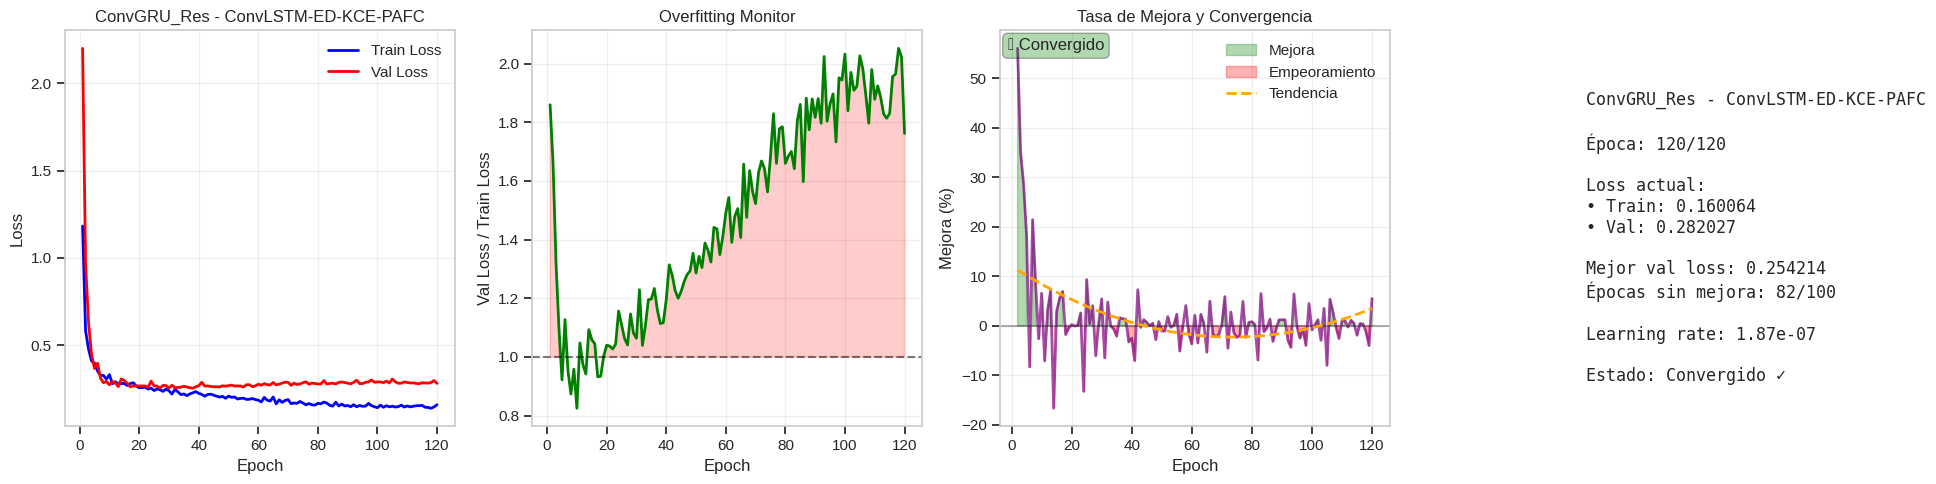


   üìä Resumen de entrenamiento ConvGRU_Res - ConvLSTM-ED-KCE-PAFC:
      ‚Ä¢ √âpocas totales: 120
      ‚Ä¢ Loss final (train): 0.160064
      ‚Ä¢ Loss final (val): 0.282027
      ‚Ä¢ Mejor loss (val): 0.254214 en √©poca 38
      ‚Ä¢ Learning rate final: No disponible


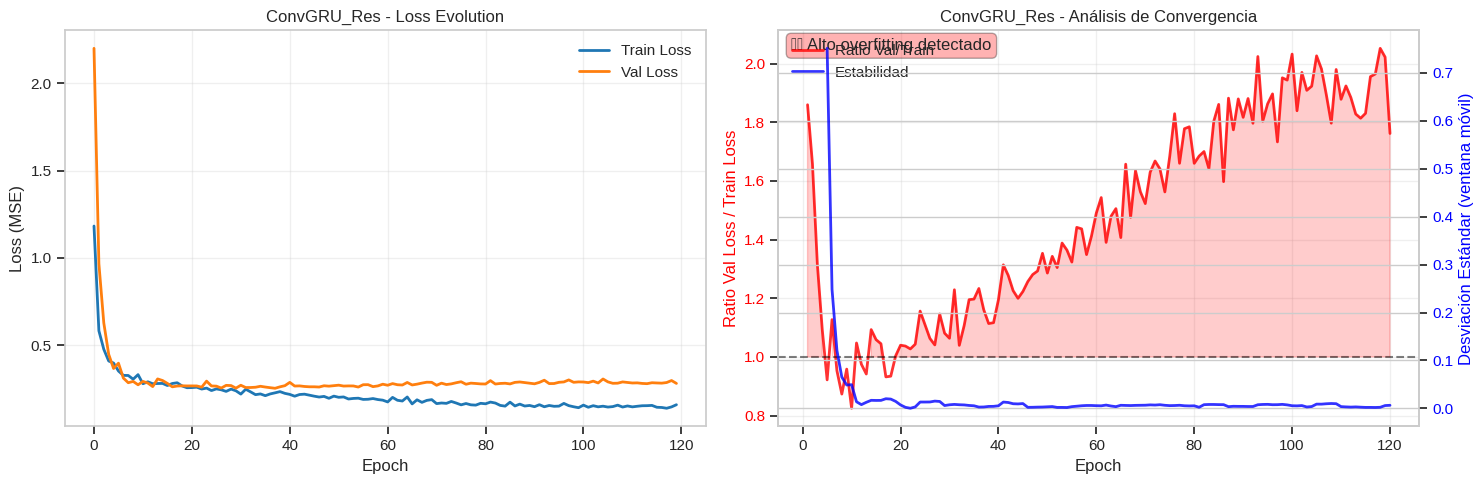


üìä Evaluando en test set...
   Test Loss: 0.376832, Test MAE: 0.443254

üéØ Generando predicciones...
   üìà H=1: RMSE=62.4110, MAE=48.7106, R¬≤=0.5060
   üìà H=2: RMSE=71.5129, MAE=57.4525, R¬≤=0.3596
   üìà H=3: RMSE=66.0517, MAE=51.9472, R¬≤=0.4625

üé® Generando visualizaciones...
   ‚úÖ GIF guardado: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE-PAFC/ConvGRU_Res.gif

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
ü§ñ Modelo: Hybrid_Trans
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   üíæ Hiperpar√°metros guardados en: Hybrid_Trans_hyperparameters.json

üèÉ Iniciando entrenamiento...
   üìä Visualizaci√≥n en tiempo real activada
   üìà Par√°metros del modelo: 41,901,557
  ‚ö†Ô∏è Error en Hybrid_Trans: Graph exe

Traceback (most recent call last):
  File "<ipython-input-9-830242408>", line 94, in <cell line: 0>
    history = model.fit(
              ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/execute.py", line 59, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/Hybrid_Transformer_1/time_distributed_2_1/strided_slice_19/StridedSliceGrad defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  F


üìë Metrics saved ‚Üí /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/metrics_advanced.csv


In [9]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ TRAIN + EVAL LOOP ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

# Diccionario para almacenar historiales de entrenamiento
all_histories = {}
results = []

for exp_name, exp_cfg in EXPERIMENTS.items():

    # Ensure the experiment is active (based on the original definition)
    if not exp_cfg.get('active', True): # Safely get 'active', default to True if missing
         print(f"\nSkipping inactive experiment: {exp_name}")
         continue

    feat_list = exp_cfg['feature_list'] # Get the list of feature names
    print(f"\n{'='*70}")
    print(f"üî¨ EXPERIMENTO: {exp_name} ({len(feat_list)} features)")
    print(f"{'='*70}")

    # Preparar datos
    Xarr = ds[feat_list].to_array().transpose('time','latitude','longitude','variable').values.astype(np.float32)
    yarr = ds['total_precipitation'].values.astype(np.float32)[...,None]
    X, y = windowed_arrays(Xarr, yarr)
    split = int(0.8*len(X))
    val_split = int(0.9*len(X))

    # Normalizaci√≥n
    sx = StandardScaler().fit(X[:split].reshape(-1,len(feat_list)))
    sy = StandardScaler().fit(y[:split].reshape(-1,1))
    X_sc = sx.transform(X.reshape(-1,len(feat_list))).reshape(X.shape)
    y_sc = sy.transform(y.reshape(-1,1)).reshape(y.shape)

    # Splits
    X_tr, X_va, X_te = X_sc[:split], X_sc[split:val_split], X_sc[val_split:]
    y_tr, y_va, y_te = y_sc[:split], y_sc[split:val_split], y_sc[val_split:]

    print(f"   Datos: Train={len(X_tr)}, Val={len(X_va)}, Test={len(X_te)}")

    OUT_EXP = OUT_ROOT/exp_name
    OUT_EXP.mkdir(exist_ok=True)

    # Crear subdirectorio para m√©tricas de entrenamiento
    METRICS_DIR = OUT_EXP / 'training_metrics'
    METRICS_DIR.mkdir(exist_ok=True)

    for mdl_name, builder in ADVANCED_MODELS.items():
        print(f"\n{'‚îÄ'*50}")
        print(f"ü§ñ Modelo: {mdl_name}")
        print(f"{'‚îÄ'*50}")

        model_path = OUT_EXP/f"{mdl_name.lower()}_best.keras"
        if model_path.exists():
            model_path.unlink()

        try:
            # Construir modelo
            model = builder(n_feats=len(feat_list))

            # Definir optimizador con configuraci√≥n expl√≠cita
            optimizer = AdamW(learning_rate=LR, weight_decay=L2_REG)
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

            # Hiperpar√°metros
            hyperparams = {
                'experiment': exp_name,
                'model': mdl_name,
                'features': [str(f) for f in feat_list],  # Convertir a strings
                'n_features': int(len(feat_list)),
                'input_window': int(INPUT_WINDOW),
                'horizon': int(HORIZON),
                'batch_size': int(BATCH_SIZE),
                'initial_lr': float(LR),
                'epochs': int(EPOCHS),
                'patience': int(PATIENCE),
                'dropout': float(DROPOUT),
                'l2_reg': float(L2_REG),
                'train_samples': int(len(X_tr)),
                'val_samples': int(len(X_va)),
                'test_samples': int(len(X_te)),
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'model_params': int(model.count_params())
            }

            # Guardar hiperpar√°metros
            save_hyperparameters(METRICS_DIR, mdl_name, hyperparams)

            # Callbacks
            callbacks = create_callbacks(mdl_name, exp_name, model_path)

            # Entrenar con verbose=0 para usar nuestro monitor personalizado
            print(f"\nüèÉ Iniciando entrenamiento...")
            print(f"   üìä Visualizaci√≥n en tiempo real activada")
            print(f"   üìà Par√°metros del modelo: {model.count_params():,}")

            history = model.fit(
                X_tr, y_tr,
                validation_data=(X_va, y_va),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                callbacks=callbacks,
                verbose=0  # Usar 0 para que solo se muestre nuestro monitor
            )

            # Guardar historial
            all_histories[f"{exp_name}_{mdl_name}"] = history

            # Mostrar resumen de entrenamiento
            print_training_summary(history, mdl_name, exp_name)

            # Plotear y guardar curvas de aprendizaje
            plot_learning_curves(history, METRICS_DIR, mdl_name, show=True)

            # Guardar historial como JSON
            # Obtener learning rates del monitor de entrenamiento si no est√°n en history
            training_monitor = [cb for cb in callbacks if isinstance(cb, AdvancedTrainingMonitor)][0]
            lr_values = history.history.get('lr', [])
            if not lr_values and hasattr(training_monitor, 'history'):
                lr_values = training_monitor.history['lr']

            history_dict = {
                'loss': [float(x) for x in history.history['loss']],
                'val_loss': [float(x) for x in history.history['val_loss']],
                'mae': [float(x) for x in history.history.get('mae', [])],
                'val_mae': [float(x) for x in history.history.get('val_mae', [])],
                'lr': [float(x) for x in lr_values] if lr_values else []
            }

            with open(METRICS_DIR / f"{mdl_name}_history.json", 'w') as f:
                json.dump(history_dict, f, indent=4)

            # ‚îÄ Evaluaci√≥n en Test Set ‚îÄ
            print(f"\nüìä Evaluando en test set...")
            test_loss, test_mae = model.evaluate(X_te, y_te, verbose=0)
            print(f"   Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.6f}")

            # ‚îÄ Predicciones y visualizaci√≥n ‚îÄ
            print(f"\nüéØ Generando predicciones...")
            # Usar las primeras 5 muestras del test set
            sample_indices = min(5, len(X_te))
            y_hat_sc = model.predict(X_te[:sample_indices], verbose=0)
            y_hat = sy.inverse_transform(y_hat_sc.reshape(-1,1)).reshape(-1,HORIZON,lat,lon)
            y_true = sy.inverse_transform(y_te[:sample_indices].reshape(-1,1)).reshape(-1,HORIZON,lat,lon)

            # ‚îÄ M√©tricas de evaluaci√≥n por horizonte ‚îÄ
            for h in range(HORIZON):
                rmse = np.sqrt(mean_squared_error(y_true[:,h].ravel(), y_hat[:,h].ravel()))
                mae = mean_absolute_error(y_true[:,h].ravel(), y_hat[:,h].ravel())
                r2 = r2_score(y_true[:,h].ravel(), y_hat[:,h].ravel())

                results.append({
                    'Experiment': exp_name,
                    'Model': mdl_name,
                    'H': h+1,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2,
                    'Test_Loss': test_loss,
                    'Parameters': model.count_params()
                })

                print(f"   üìà H={h+1}: RMSE={rmse:.4f}, MAE={mae:.4f}, R¬≤={r2:.4f}")

            # ‚îÄ Mapas & GIF ‚îÄ
            print(f"\nüé® Generando visualizaciones...")
            # Usar la primera muestra para visualizaci√≥n
            sample_idx = 0
            vmin, vmax = 0, max(y_true[sample_idx].max(), y_hat[sample_idx].max())
            frames = []
            dates = pd.date_range(ds.time.values[-HORIZON], periods=HORIZON, freq='MS')

            for h in range(HORIZON):
                err = np.clip(np.abs((y_true[sample_idx,h]-y_hat[sample_idx,h])/(y_true[sample_idx,h]+1e-5))*100, 0, 100)
                try:
                    import cartopy.crs as ccrs
                    fig, axs = plt.subplots(1, 3, figsize=(16, 4.5), subplot_kw={'projection': ccrs.PlateCarree()})
                except ImportError:
                    fig, axs = plt.subplots(1, 3, figsize=(16, 4.5))

                # Real
                real_mesh = axs[0].pcolormesh(ds.longitude, ds.latitude, y_true[sample_idx,h],
                                            cmap='Blues', shading='nearest', vmin=vmin, vmax=vmax,
                                            transform=ccrs.PlateCarree())
                axs[0].coastlines()
                axs[0].add_geometries(DEPT_GDF.geometry, ccrs.PlateCarree(),
                                    edgecolor='black', facecolor='none', linewidth=1)
                axs[0].gridlines(draw_labels=False, linewidth=.5, linestyle='--', alpha=.4)
                axs[0].set_title(f"Real h={h+1}", fontsize=11)
                real_cbar = fig.colorbar(real_mesh, ax=axs[0], fraction=0.046, pad=0.04)
                real_cbar.set_label('Precipitaci√≥n (mm)', rotation=270, labelpad=15)

                # Predicci√≥n
                pred_mesh = axs[1].pcolormesh(ds.longitude, ds.latitude, y_hat[sample_idx,h],
                                            cmap='Blues', shading='nearest', vmin=vmin, vmax=vmax,
                                            transform=ccrs.PlateCarree())
                axs[1].coastlines()
                axs[1].add_geometries(DEPT_GDF.geometry, ccrs.PlateCarree(),
                                     edgecolor='black', facecolor='none', linewidth=1)
                axs[1].gridlines(draw_labels=False, linewidth=.5, linestyle='--', alpha=.4)
                axs[1].set_title(f"{mdl_name} h={h+1}", fontsize=11)
                pred_cbar = fig.colorbar(pred_mesh, ax=axs[1], fraction=0.046, pad=0.04)
                pred_cbar.set_label('Precipitaci√≥n (mm)', rotation=270, labelpad=15)

                # Error
                err_mesh = axs[2].pcolormesh(ds.longitude, ds.latitude, err,
                                           cmap='Reds', shading='nearest', vmin=0, vmax=100,
                                           transform=ccrs.PlateCarree())
                axs[2].coastlines()
                axs[2].add_geometries(DEPT_GDF.geometry, ccrs.PlateCarree(),
                                    edgecolor='black', facecolor='none', linewidth=1)
                axs[2].gridlines(draw_labels=False, linewidth=.5, linestyle='--', alpha=.4)
                axs[2].set_title(f"MAPE% h={h+1}", fontsize=11)
                err_cbar = fig.colorbar(err_mesh, ax=axs[2], fraction=0.046, pad=0.04)
                err_cbar.set_label('MAPE (%)', rotation=270, labelpad=15)

                fig.suptitle(f"{mdl_name} ‚Äì {exp_name} ‚Äì {dates[h].strftime('%Y-%m')}", fontsize=13)
                png = OUT_EXP/f"{mdl_name}_{h+1}.png"
                fig.tight_layout()
                fig.savefig(png, bbox_inches='tight')
                plt.close(fig)
                frames.append(imageio.imread(png))

            imageio.mimsave(OUT_EXP/f"{mdl_name}.gif", frames, fps=0.5)
            print(f"   ‚úÖ GIF guardado: {OUT_EXP/f'{mdl_name}.gif'}")

            tf.keras.backend.clear_session()
            gc.collect()

        except Exception as e:
            print(f"  ‚ö†Ô∏è Error en {mdl_name}: {str(e)}")
            print(f"  ‚Üí Saltando {mdl_name} para {exp_name}")
            import traceback
            traceback.print_exc()
            continue

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ CSV FINAL ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
res_df = pd.DataFrame(results)
res_df.to_csv(OUT_ROOT/'metrics_advanced.csv', index=False)
print("\nüìë Metrics saved ‚Üí", OUT_ROOT/'metrics_advanced.csv')



üìä GENERANDO VISUALIZACIONES COMPARATIVAS


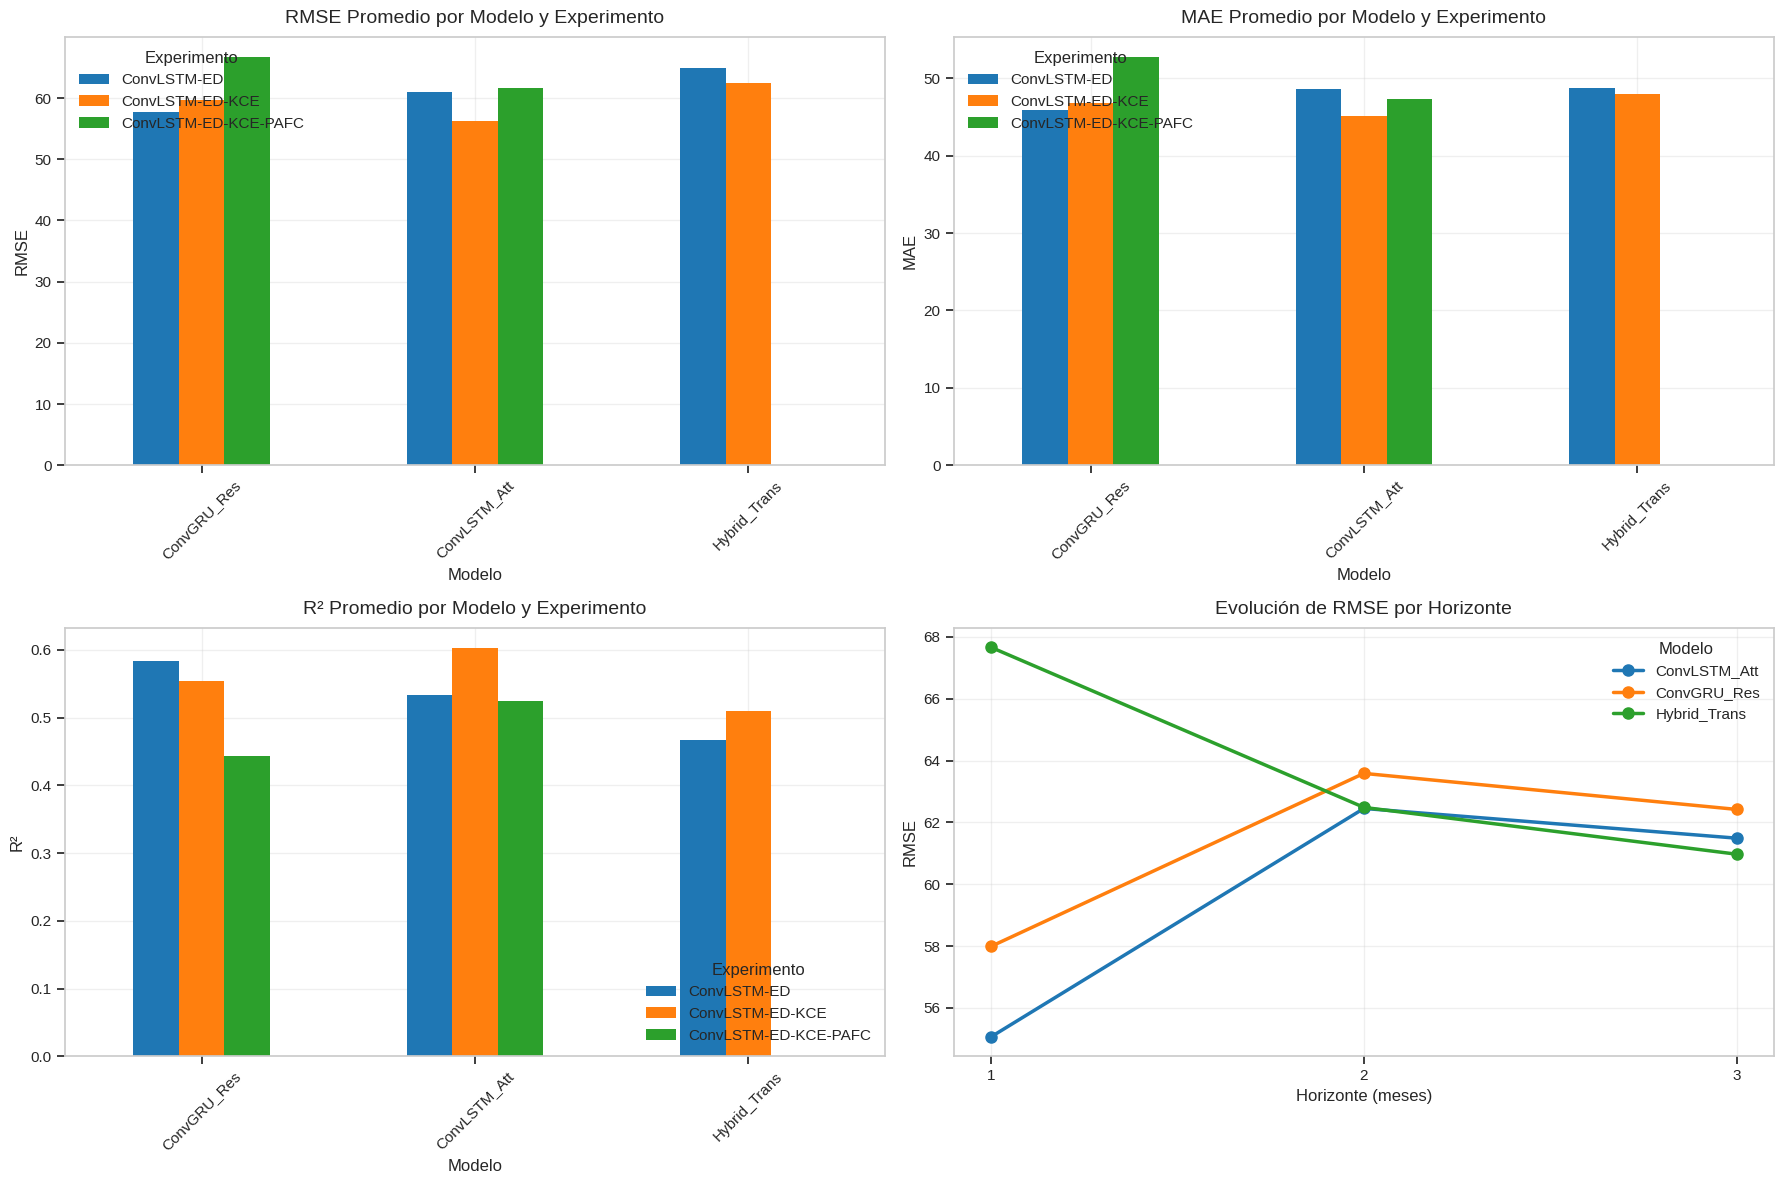


üìã TABLA RESUMEN - MEJORES MODELOS POR EXPERIMENTO:
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
                             Model       RMSE        MAE        R2
Experiment                                                        
ConvLSTM-ED            ConvGRU_Res  53.928926  43.005478  0.631183
ConvLSTM-ED-KCE       ConvLSTM_Att  51.875925  40.576065  0.658729
ConvLSTM-ED-KCE-PAFC  ConvLSTM_Att  58.310689  44.053493  0.568815

üìä COMPARACI√ìN CON MODELOS ORIGINALES:
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

ConvLSTM-ED:
  ‚Ä¢ No hay datos originales para comparar

ConvLSTM-ED-KCE:
  ‚Ä¢ No hay datos originales para comparar

ConvLSTM-ED-KCE-PAFC:
  ‚Ä¢ No hay datos originales para comparar

‚úÖ Visualizacion

In [10]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ VISUALIZACI√ìN COMPARATIVA ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print("\n" + "="*70)
print("üìä GENERANDO VISUALIZACIONES COMPARATIVAS")
print("="*70)

# Crear directorio para comparaciones
COMP_DIR = OUT_ROOT / 'comparisons'
COMP_DIR.mkdir(exist_ok=True)

# 1. Comparaci√≥n de m√©tricas entre modelos
if 'res_df' in locals() and res_df is not None and len(res_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # RMSE por modelo y experimento
    pivot_rmse = res_df.pivot_table(values='RMSE', index='Model', columns='Experiment', aggfunc='mean')
    pivot_rmse.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('RMSE Promedio por Modelo y Experimento', fontsize=14, pad=10)
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].set_xlabel('Modelo')
    axes[0,0].legend(title='Experimento', loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)

    # MAE por modelo y experimento
    pivot_mae = res_df.pivot_table(values='MAE', index='Model', columns='Experiment', aggfunc='mean')
    pivot_mae.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('MAE Promedio por Modelo y Experimento', fontsize=14, pad=10)
    axes[0,1].set_ylabel('MAE')
    axes[0,1].set_xlabel('Modelo')
    axes[0,1].legend(title='Experimento', loc='upper left')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)

    # R¬≤ por modelo y experimento
    pivot_r2 = res_df.pivot_table(values='R2', index='Model', columns='Experiment', aggfunc='mean')
    pivot_r2.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('R¬≤ Promedio por Modelo y Experimento', fontsize=14, pad=10)
    axes[1,0].set_ylabel('R¬≤')
    axes[1,0].set_xlabel('Modelo')
    axes[1,0].legend(title='Experimento', loc='lower right')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].tick_params(axis='x', rotation=45)

    # Evoluci√≥n de m√©tricas por horizonte
    ax_horizon = axes[1,1]

    for model in res_df['Model'].unique():
        model_data = res_df[res_df['Model'] == model]
        horizon_means = model_data.groupby('H')['RMSE'].mean()
        ax_horizon.plot(horizon_means.index, horizon_means.values,
                       marker='o', label=model, linewidth=2.5, markersize=8)

    ax_horizon.set_xlabel('Horizonte (meses)')
    ax_horizon.set_ylabel('RMSE')
    ax_horizon.set_title('Evoluci√≥n de RMSE por Horizonte', fontsize=14, pad=10)
    ax_horizon.legend(title='Modelo', loc='best')
    ax_horizon.grid(True, alpha=0.3)
    ax_horizon.set_xticks([1, 2, 3])

    plt.tight_layout()
    plt.savefig(COMP_DIR / 'metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# 2. Tabla resumen de mejores modelos
if 'res_df' in locals() and res_df is not None and len(res_df) > 0:
    print("\nüìã TABLA RESUMEN - MEJORES MODELOS POR EXPERIMENTO:")
    print("‚îÄ" * 60)

    best_models = res_df.groupby('Experiment').apply(
        lambda x: x.loc[x['RMSE'].idxmin()]
    )[['Model', 'RMSE', 'MAE', 'R2']]

    print(best_models.to_string())
else:
    print("\n‚ö†Ô∏è No hay resultados disponibles para mostrar el resumen")

# 3. Comparaci√≥n con modelos originales si existen
old_metrics_path = BASE_PATH / 'models' / 'output' / 'Spatial_CONVRNN' / 'metrics_spatial.csv'
if old_metrics_path.exists():
    print("\nüìä COMPARACI√ìN CON MODELOS ORIGINALES:")
    print("‚îÄ" * 60)

    old_df = pd.read_csv(old_metrics_path)

    # Calcular mejoras promedio
    if 'res_df' in locals() and res_df is not None and len(res_df) > 0:
        for exp in EXPERIMENTS.keys():
            print(f"\n{exp}:")

            # Mejores modelos nuevos
            exp_data = res_df[res_df['Experiment'] == exp]
            if len(exp_data) > 0:
                new_best = exp_data.groupby('Model')['RMSE'].mean().idxmin()
                new_rmse = exp_data[exp_data['Model'] == new_best]['RMSE'].mean()

                # Mejor modelo original
                old_exp_data = old_df[old_df['Experiment'] == exp]
                if len(old_exp_data) > 0:
                    old_best_rmse = old_exp_data['RMSE'].min()

                    improvement = (old_best_rmse - new_rmse) / old_best_rmse * 100

                    print(f"  ‚Ä¢ Mejor modelo nuevo: {new_best} (RMSE: {new_rmse:.4f})")
                    print(f"  ‚Ä¢ Mejor RMSE original: {old_best_rmse:.4f}")
                    print(f"  ‚Ä¢ Mejora: {improvement:.2f}%")
                else:
                    print(f"  ‚Ä¢ No hay datos originales para comparar")

print("\n‚úÖ Visualizaciones comparativas completadas!")
print(f"üìÇ Resultados guardados en: {COMP_DIR}")



üìä AN√ÅLISIS DETALLADO DE RESULTADOS


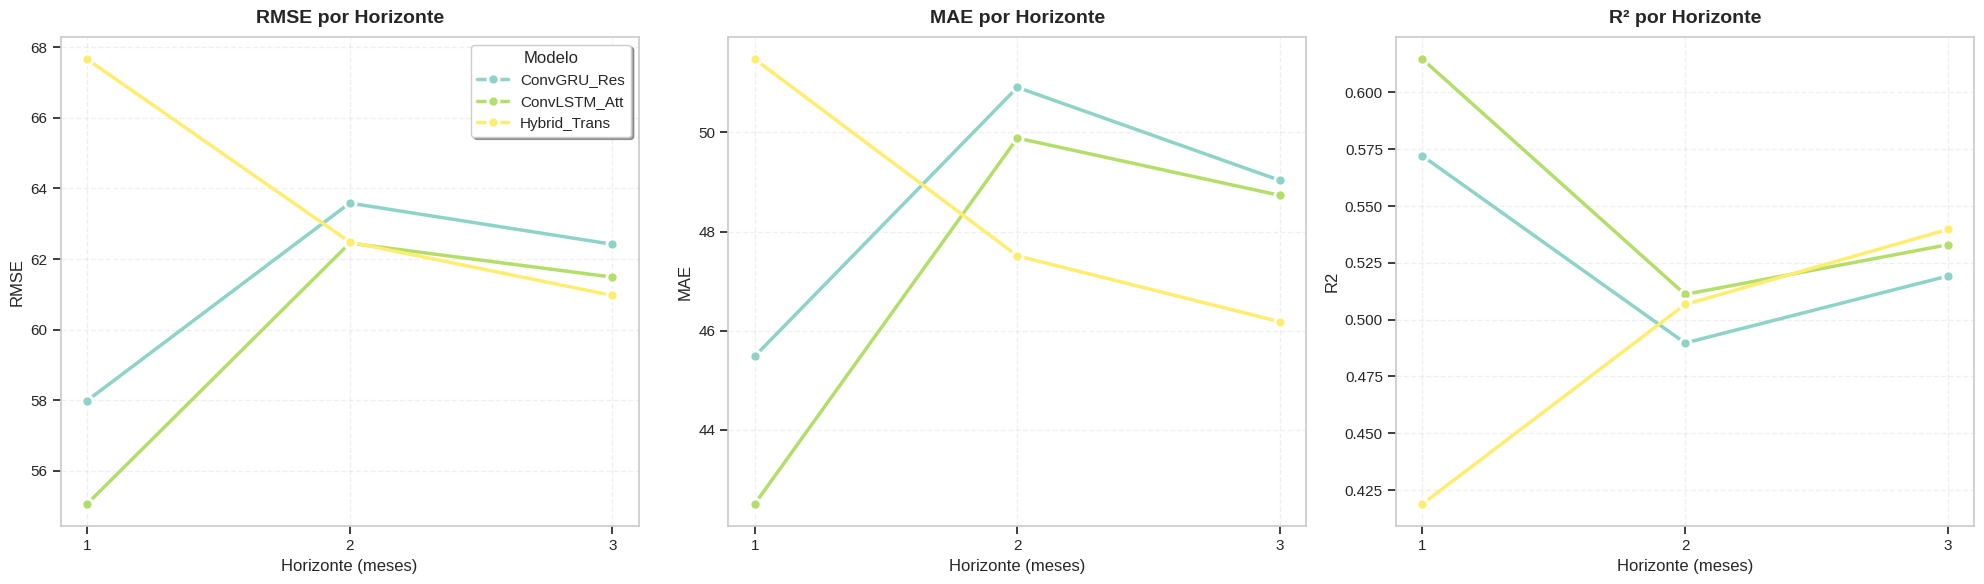

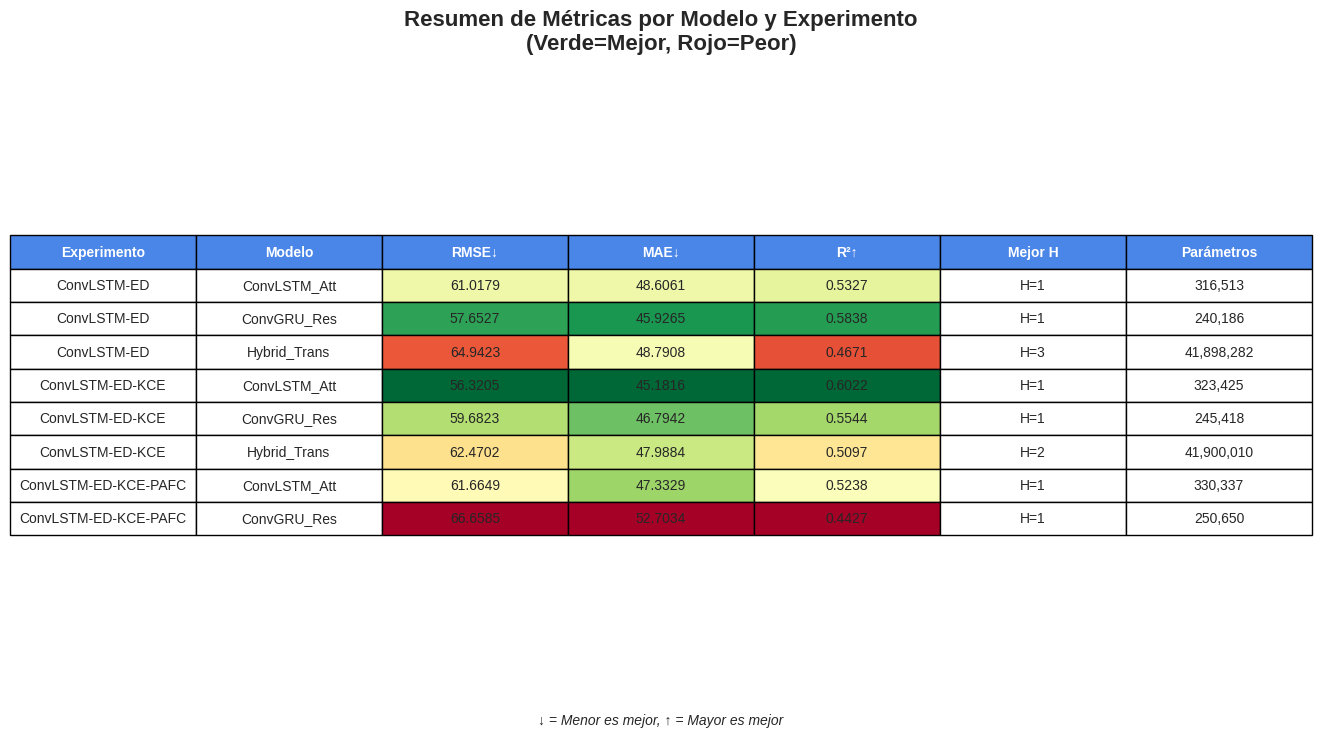


üèÜ MEJOR MODELO GLOBAL:
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Modelo: ConvLSTM_Att
Experimento: ConvLSTM-ED-KCE
Horizonte: 1
RMSE: 51.8759
MAE: 40.5761
R¬≤: 0.6587
Score compuesto: 1.0000

üìà AN√ÅLISIS DE MEJORA POR HORIZONTE:
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

Horizonte 1:
  ‚Ä¢ Mejor modelo: ConvLSTM_Att - ConvLSTM-ED-KCE
  ‚Ä¢ RMSE: 51.8759
  ‚Ä¢ R¬≤: 0.6587

Horizonte 2:
  ‚Ä¢ Mejor modelo: Hybrid_Trans - ConvLSTM-ED-KCE
  ‚Ä¢ RMSE: 56.5467
  ‚Ä¢ R¬≤: 0.5996

Horizonte 3:
  ‚Ä¢ Mejor modelo: Hybrid_Trans - ConvLSTM-ED
  ‚Ä¢ RMSE: 56.6279
  ‚Ä¢ R¬≤: 0.6049

‚úÖ An√°lisis detallado completado!


In [11]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ AN√ÅLISIS DETALLADO DE RESULTADOS ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

if 'res_df' in locals() and res_df is not None and len(res_df) > 0:
    print("\n" + "="*70)
    print("üìä AN√ÅLISIS DETALLADO DE RESULTADOS")
    print("="*70)

    # 1. M√©tricas por horizonte de predicci√≥n
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    metrics = ['RMSE', 'MAE', 'R2']
    titles = ['RMSE por Horizonte', 'MAE por Horizonte', 'R¬≤ por Horizonte']
    colors = plt.cm.Set3(np.linspace(0, 1, len(res_df['Model'].unique())))

    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx]

        # Obtener datos pivoteados
        data = res_df.groupby(['H', 'Model'])[metric].mean().unstack()

        # Plotear cada modelo
        for i, model in enumerate(data.columns):
            ax.plot(data.index, data[model],
                   marker='o',
                   label=model,
                   color=colors[i],
                   linewidth=2.5,
                   markersize=8,
                   markeredgewidth=2,
                   markeredgecolor='white')

        ax.set_xlabel('Horizonte (meses)', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xticks(data.index)

        # Leyenda solo en el primer gr√°fico
        if idx == 0:
            ax.legend(title='Modelo', loc='best', frameon=True, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.savefig(COMP_DIR / 'metrics_evolution_by_horizon.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 2. Tabla visual de m√©tricas
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')

    # Preparar datos para la tabla
    summary_data = []
    experiments = res_df['Experiment'].unique()
    models = res_df['Model'].unique()

    # Headers
    headers = ['Experimento', 'Modelo', 'RMSE‚Üì', 'MAE‚Üì', 'R¬≤‚Üë', 'Mejor H', 'Par√°metros']

    for exp in experiments:
        for model in models:
            exp_model_data = res_df[(res_df['Experiment'] == exp) & (res_df['Model'] == model)]
            if not exp_model_data.empty:
                avg_rmse = exp_model_data['RMSE'].mean()
                avg_mae = exp_model_data['MAE'].mean()
                avg_r2 = exp_model_data['R2'].mean()
                best_h = exp_model_data.loc[exp_model_data['RMSE'].idxmin(), 'H']
                params = exp_model_data['Parameters'].iloc[0]

                summary_data.append([
                    exp, model,
                    f'{avg_rmse:.4f}',
                    f'{avg_mae:.4f}',
                    f'{avg_r2:.4f}',
                    f'H={best_h}',
                    f'{params:,}'
                ])

    # Crear tabla
    table = ax.table(cellText=summary_data, colLabels=headers,
                    cellLoc='center', loc='center')

    # Estilizar tabla
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)

    # Colorear celdas seg√∫n rendimiento
    for i in range(len(summary_data)):
        # Obtener valores para comparaci√≥n
        rmse_val = float(summary_data[i][2])
        mae_val = float(summary_data[i][3])
        r2_val = float(summary_data[i][4])

        # Encontrar min/max para normalizaci√≥n
        all_rmse = [float(row[2]) for row in summary_data]
        all_mae = [float(row[3]) for row in summary_data]
        all_r2 = [float(row[4]) for row in summary_data]

        # Normalizar y colorear RMSE (menor es mejor)
        rmse_norm = (rmse_val - min(all_rmse)) / (max(all_rmse) - min(all_rmse))
        rmse_color = plt.cm.RdYlGn(1 - rmse_norm)
        table[(i+1, 2)].set_facecolor(rmse_color)

        # Normalizar y colorear MAE (menor es mejor)
        mae_norm = (mae_val - min(all_mae)) / (max(all_mae) - min(all_mae))
        mae_color = plt.cm.RdYlGn(1 - mae_norm)
        table[(i+1, 3)].set_facecolor(mae_color)

        # Normalizar y colorear R¬≤ (mayor es mejor)
        r2_norm = (r2_val - min(all_r2)) / (max(all_r2) - min(all_r2))
        r2_color = plt.cm.RdYlGn(r2_norm)
        table[(i+1, 4)].set_facecolor(r2_color)

        # Colorear experimento
        exp_colors = {'BASIC': '#e8f4f8', 'KCE': '#f0e8f8', 'PAFC': '#f8e8f0'}
        table[(i+1, 0)].set_facecolor(exp_colors.get(summary_data[i][0], 'white'))

    # Colorear headers
    for j in range(len(headers)):
        table[(0, j)].set_facecolor('#4a86e8')
        table[(0, j)].set_text_props(weight='bold', color='white')

    plt.title('Resumen de M√©tricas por Modelo y Experimento\n(Verde=Mejor, Rojo=Peor)',
             fontsize=16, fontweight='bold', pad=20)

    # A√±adir leyenda
    plt.text(0.5, -0.05, '‚Üì = Menor es mejor, ‚Üë = Mayor es mejor',
            transform=ax.transAxes, ha='center', fontsize=10, style='italic')

    plt.savefig(COMP_DIR / 'metrics_summary_table.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 3. Identificar el mejor modelo global
    print("\nüèÜ MEJOR MODELO GLOBAL:")
    print("‚îÄ" * 50)

    # Calcular score compuesto (normalizado)
    res_df['score'] = (
        (1 - (res_df['RMSE'] - res_df['RMSE'].min()) / (res_df['RMSE'].max() - res_df['RMSE'].min())) +
        (1 - (res_df['MAE'] - res_df['MAE'].min()) / (res_df['MAE'].max() - res_df['MAE'].min())) +
        ((res_df['R2'] - res_df['R2'].min()) / (res_df['R2'].max() - res_df['R2'].min()))
    ) / 3

    best_overall = res_df.loc[res_df['score'].idxmax()]
    print(f"Modelo: {best_overall['Model']}")
    print(f"Experimento: {best_overall['Experiment']}")
    print(f"Horizonte: {best_overall['H']}")
    print(f"RMSE: {best_overall['RMSE']:.4f}")
    print(f"MAE: {best_overall['MAE']:.4f}")
    print(f"R¬≤: {best_overall['R2']:.4f}")
    print(f"Score compuesto: {best_overall['score']:.4f}")

    # 4. An√°lisis de mejora por horizonte
    print("\nüìà AN√ÅLISIS DE MEJORA POR HORIZONTE:")
    print("‚îÄ" * 50)

    for h in [1, 2, 3]:
        h_data = res_df[res_df['H'] == h]
        best_h = h_data.loc[h_data['RMSE'].idxmin()]

        print(f"\nHorizonte {h}:")
        print(f"  ‚Ä¢ Mejor modelo: {best_h['Model']} - {best_h['Experiment']}")
        print(f"  ‚Ä¢ RMSE: {best_h['RMSE']:.4f}")
        print(f"  ‚Ä¢ R¬≤: {best_h['R2']:.4f}")

print("\n‚úÖ An√°lisis detallado completado!")



üñºÔ∏è PREDICCIONES M√ÅS RECIENTES:

ConvLSTM-ED:
  ConvLSTM_Att - Primera predicci√≥n (H=1):


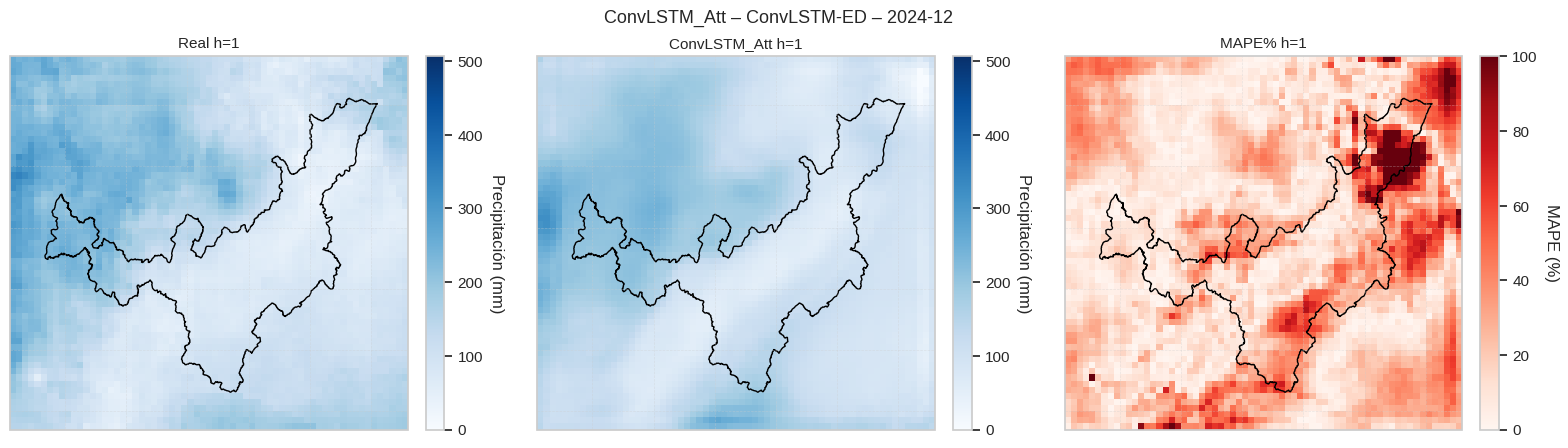

  üìπ GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED/ConvLSTM_Att.gif
  ConvGRU_Res - Primera predicci√≥n (H=1):


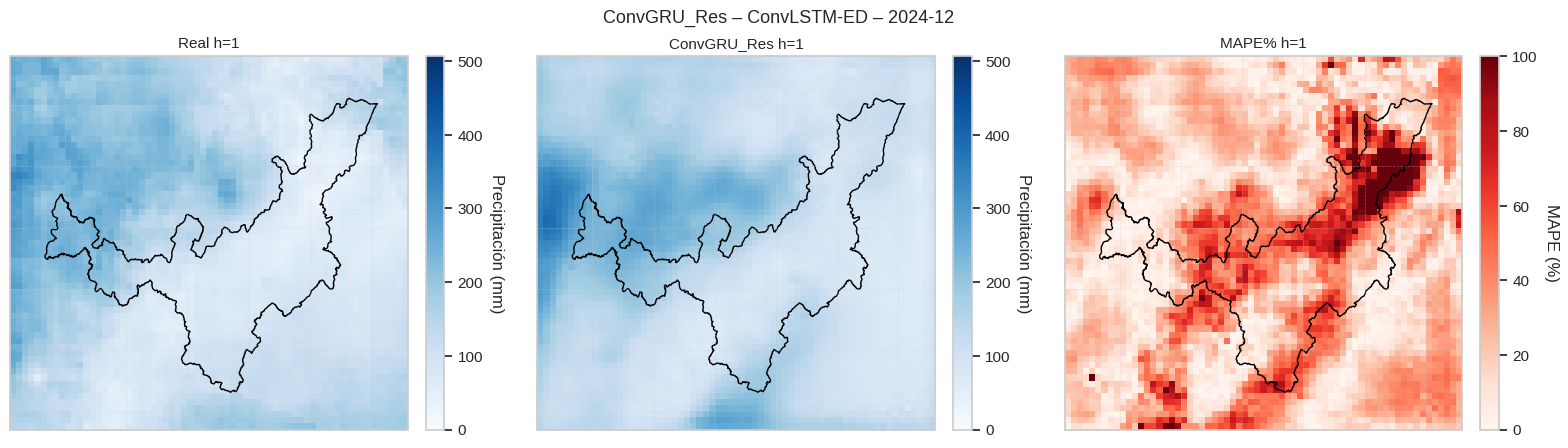

  üìπ GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED/ConvGRU_Res.gif
  Hybrid_Trans - Primera predicci√≥n (H=1):


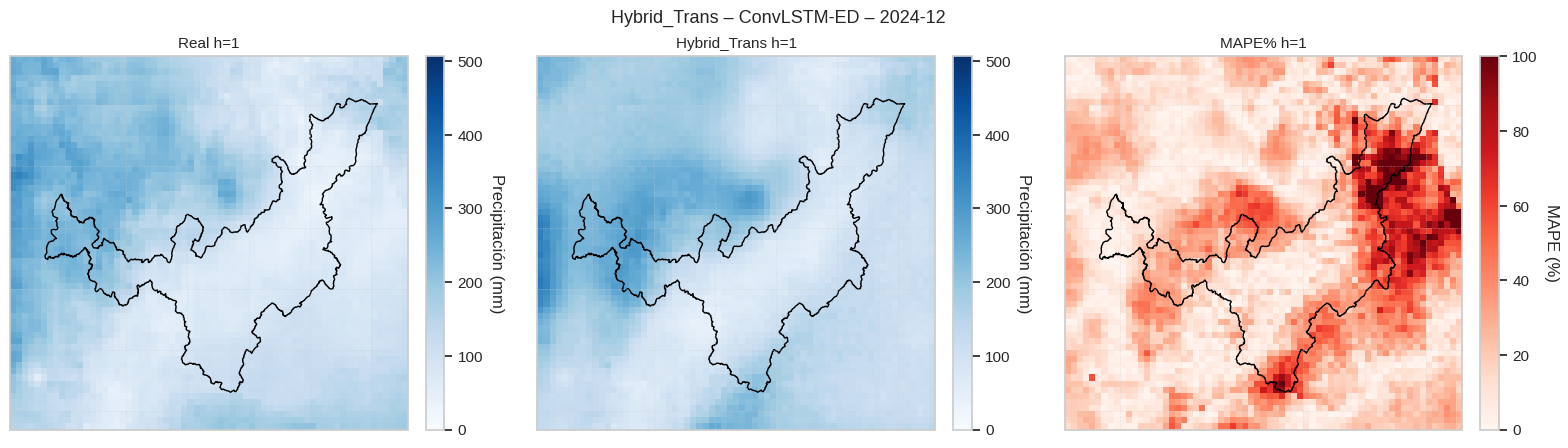

  üìπ GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED/Hybrid_Trans.gif

ConvLSTM-ED-KCE:
  ConvLSTM_Att - Primera predicci√≥n (H=1):


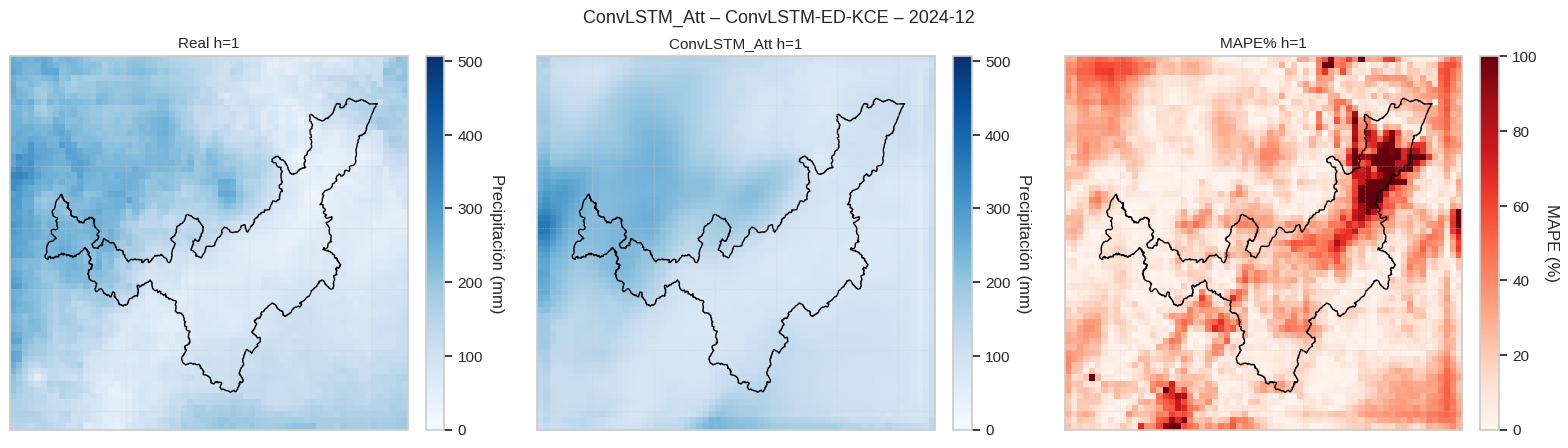

  üìπ GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE/ConvLSTM_Att.gif
  ConvGRU_Res - Primera predicci√≥n (H=1):


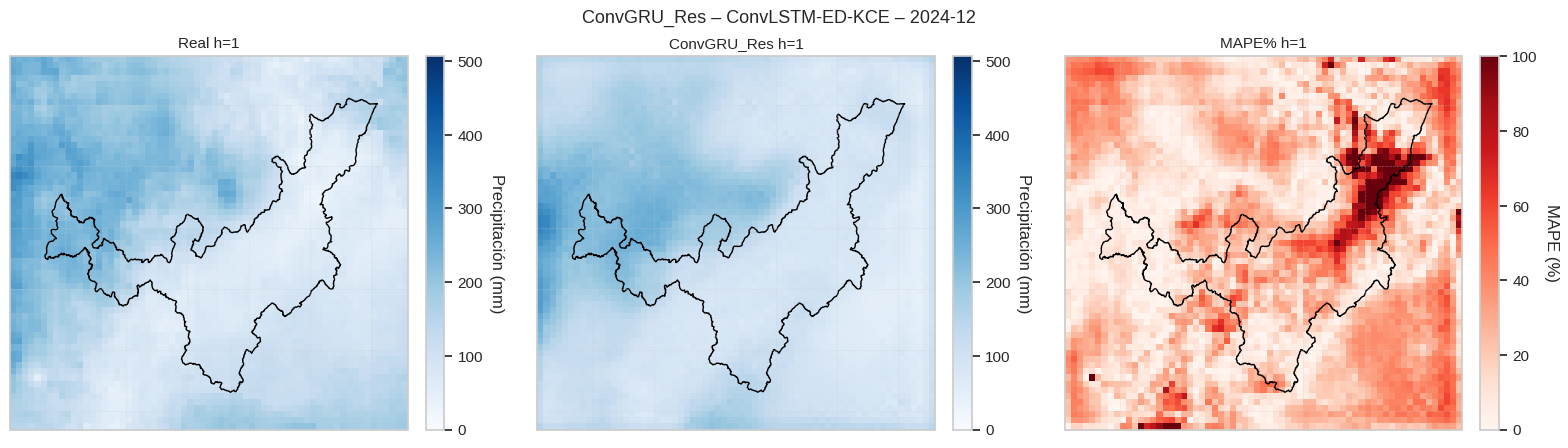

  üìπ GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE/ConvGRU_Res.gif
  Hybrid_Trans - Primera predicci√≥n (H=1):


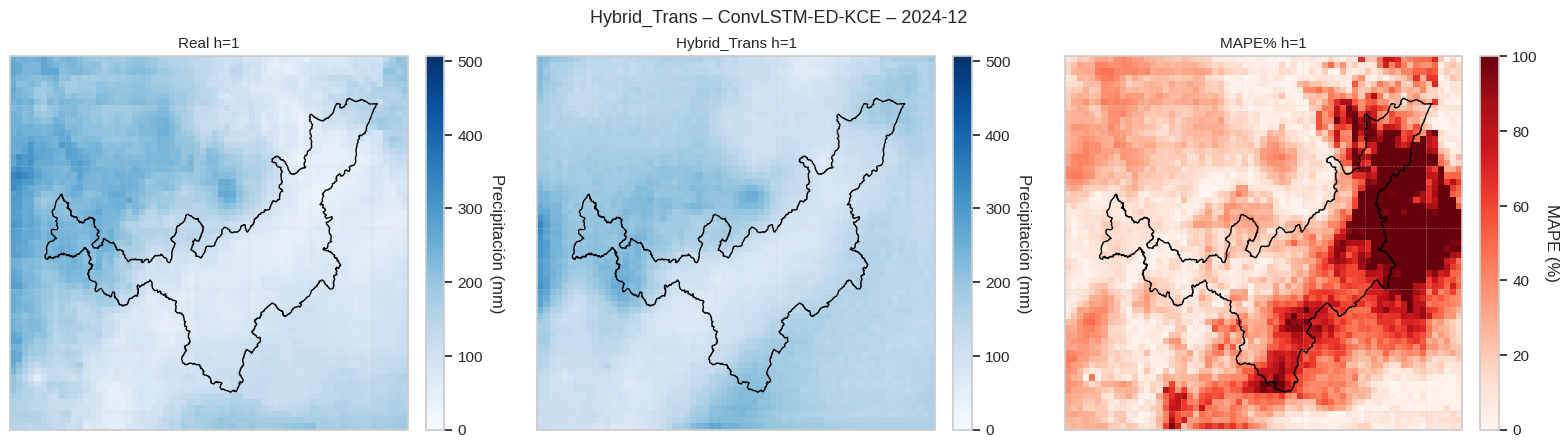

  üìπ GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE/Hybrid_Trans.gif

ConvLSTM-ED-KCE-PAFC:
  ConvLSTM_Att - Primera predicci√≥n (H=1):


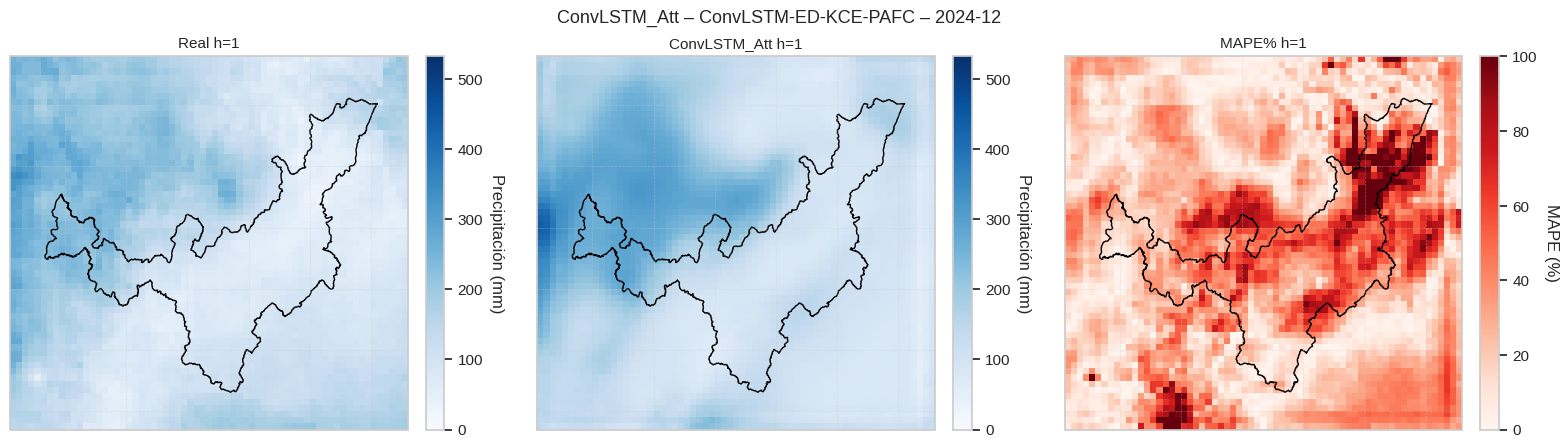

  üìπ GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE-PAFC/ConvLSTM_Att.gif
  ConvGRU_Res - Primera predicci√≥n (H=1):


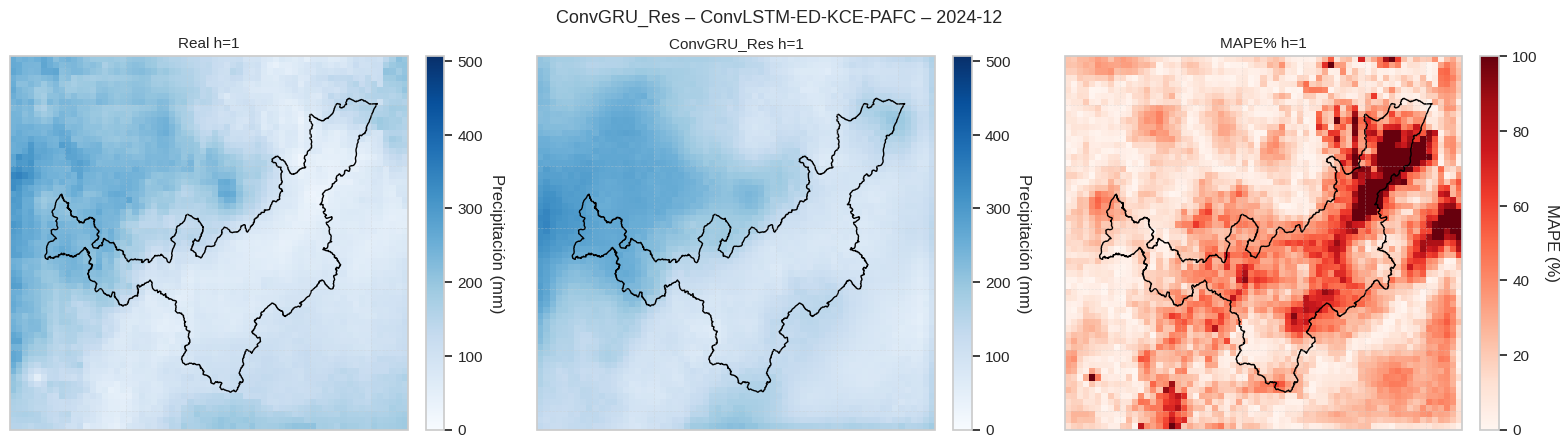

  üìπ GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE-PAFC/ConvGRU_Res.gif

üéâ NOTEBOOK COMPLETADO!

üìä Resultados guardados en: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial
üìà M√©tricas en: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/metrics_advanced.csv
üñºÔ∏è Visualizaciones en: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/comparisons

üí° Pr√≥ximos pasos:
   1. Revisar las m√©tricas y seleccionar el mejor modelo
   2. Hacer fine-tuning de hiperpar√°metros si es necesario
   3. Entrenar un ensemble con los mejores modelos
   4. Evaluar en datos m√°s recientes o diferentes regiones


In [12]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ MOSTRAR PREDICCIONES M√ÅS RECIENTES ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print("\nüñºÔ∏è PREDICCIONES M√ÅS RECIENTES:")
for exp in EXPERIMENTS.keys():
    exp_dir = OUT_ROOT / exp
    if exp_dir.exists():
        print(f"\n{exp}:")
        # Mostrar primera imagen de cada modelo
        for model in ADVANCED_MODELS.keys():
            img_path = exp_dir / f"{model}_1.png"
            gif_path = exp_dir / f"{model}.gif"

            if img_path.exists():
                from IPython.display import Image, display
                print(f"  {model} - Primera predicci√≥n (H=1):")
                display(Image(str(img_path), width=800))

            if gif_path.exists():
                print(f"  üìπ GIF animado disponible: {gif_path}")

print("\n" + "="*70)
print("üéâ NOTEBOOK COMPLETADO!")
print("="*70)
print(f"\nüìä Resultados guardados en: {OUT_ROOT}")
if 'res_df' in locals() and res_df is not None and len(res_df) > 0:
    print(f"üìà M√©tricas en: {OUT_ROOT/'metrics_advanced.csv'}")
    print(f"üñºÔ∏è Visualizaciones en: {COMP_DIR if 'COMP_DIR' in locals() else 'N/A'}")
else:
    print("‚ö†Ô∏è No se generaron m√©tricas en esta ejecuci√≥n")
print("\nüí° Pr√≥ximos pasos:")
print("   1. Revisar las m√©tricas y seleccionar el mejor modelo")
print("   2. Hacer fine-tuning de hiperpar√°metros si es necesario")
print("   3. Entrenar un ensemble con los mejores modelos")
print("   4. Evaluar en datos m√°s recientes o diferentes regiones")
